In [183]:
import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split, GridSearchCV, cross_val_score
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_absolute_percentage_error, mean_absolute_error
from sklearn.inspection import permutation_importance
from sklearn.gaussian_process import GaussianProcessRegressor
from sklearn import linear_model
from sklearn.linear_model import LinearRegression
import shap
import seaborn as sns
import matplotlib.pyplot as plt
from mpl_toolkits.axes_grid1 import make_axes_locatable


from artemis.interactions_methods.model_agnostic import FriedmanHStatisticMethod

In [ ]:
##plot parameters for journal

from matplotlib_inline.backend_inline import set_matplotlib_formats
set_matplotlib_formats('retina')
plt.style.use('seaborn-v0_8-notebook')

width = 3.25
height = 4
plt.rcParams['figure.autolayout'] = True
plt.rcParams['lines.linewidth'] = 1
plt.rcParams['font.size'] = 12
plt.rcParams['font.sans-serif'] = 'Arial'
plt.rcParams['mathtext.fontset'] = 'custom'
plt.rcParams['mathtext.rm'] = 'Arial'
plt.rcParams['pdf.fonttype'] = 42
plt.rcParams['ps.fonttype'] = 42


In [241]:
raw_data = raw_data = pd.read_csv('raw_data.csv')

raw_data['dSOH/dNeq'] = raw_data['dSOH/dNeq'] + 5

In [242]:
raw_data['dSOH/dNeq']

0      5.000000
1      5.011460
2      5.022220
3      5.031840
4      5.061800
         ...   
247    5.171584
248    5.143184
249    5.124840
250    5.084500
251    5.054300
Name: dSOH/dNeq, Length: 252, dtype: float64

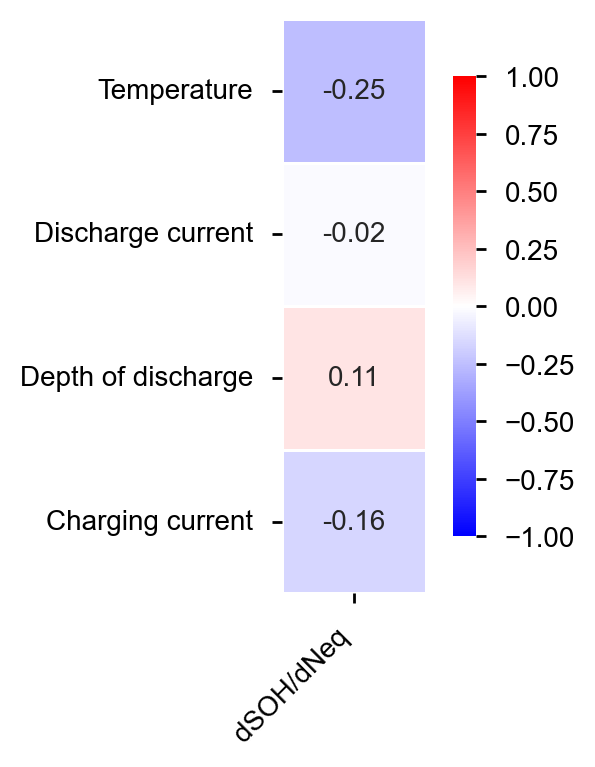

In [243]:
# Compute correlation matrix
corr = raw_data[['Ambient temperature', 'Discharging current', 'Depth of discharge',
                 'Average charging current', 'dSOH/dNeq']].corr()


target_corr = corr[['dSOH/dNeq']].drop(index='dSOH/dNeq')
target_corr.index = ['Temperature', 'Discharge current', 'Depth of discharge', 'Charging current']

plt.figure(figsize=(width, height))
sns.heatmap(
    target_corr,
    annot=True,
    fmt=".2f",
    cmap="bwr",
    vmin=-1, vmax=1,
    center=0,
    linewidths=0.5,
    annot_kws={"size": 10},
    cbar_kws={"shrink": 0.8},
    square=True
)

plt.xticks(rotation=45, ha='right')
plt.yticks(rotation=0)
# plt.title("Feature Correlation with dSOH/dNeq")
plt.tight_layout()
plt.show()

In [244]:
SOH_100 = pd.DataFrame(raw_data.loc[(raw_data["State of Health"] == 1.000)].sort_values(by=["cell_name"]))
SOH_0975 = pd.DataFrame(raw_data.loc[(raw_data["State of Health"] == 0.975)].sort_values(by=["cell_name"]))
SOH_0950 = pd.DataFrame(raw_data.loc[(raw_data["State of Health"] == 0.950)].sort_values(by=["cell_name"]))
SOH_0925 = pd.DataFrame(raw_data.loc[(raw_data["State of Health"] == 0.925)].sort_values(by=["cell_name"]))
SOH_0900 = pd.DataFrame(raw_data.loc[(raw_data["State of Health"] == 0.900)].sort_values(by=["cell_name"]))
SOH_0875 = pd.DataFrame(raw_data.loc[(raw_data["State of Health"] == 0.875)].sort_values(by=["cell_name"]))
SOH_0850 = pd.DataFrame(raw_data.loc[(raw_data["State of Health"] == 0.850)].sort_values(by=["cell_name"]))
SOH_0825 = pd.DataFrame(raw_data.loc[(raw_data["State of Health"] == 0.825)].sort_values(by=["cell_name"]))
SOH_0800 = pd.DataFrame(raw_data.loc[(raw_data["State of Health"] == 0.800)].sort_values(by=["cell_name"]))

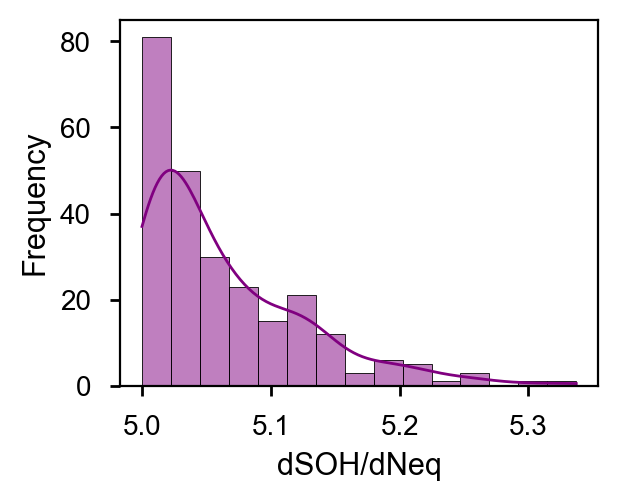

In [252]:
plt.figure(figsize= (width, height/1.5))
sns.histplot(raw_data['dSOH/dNeq'], kde=True, color='purple')
plt.xlabel('dSOH/dNeq')
plt.ylabel('Frequency')
plt.show()

### Linear regression

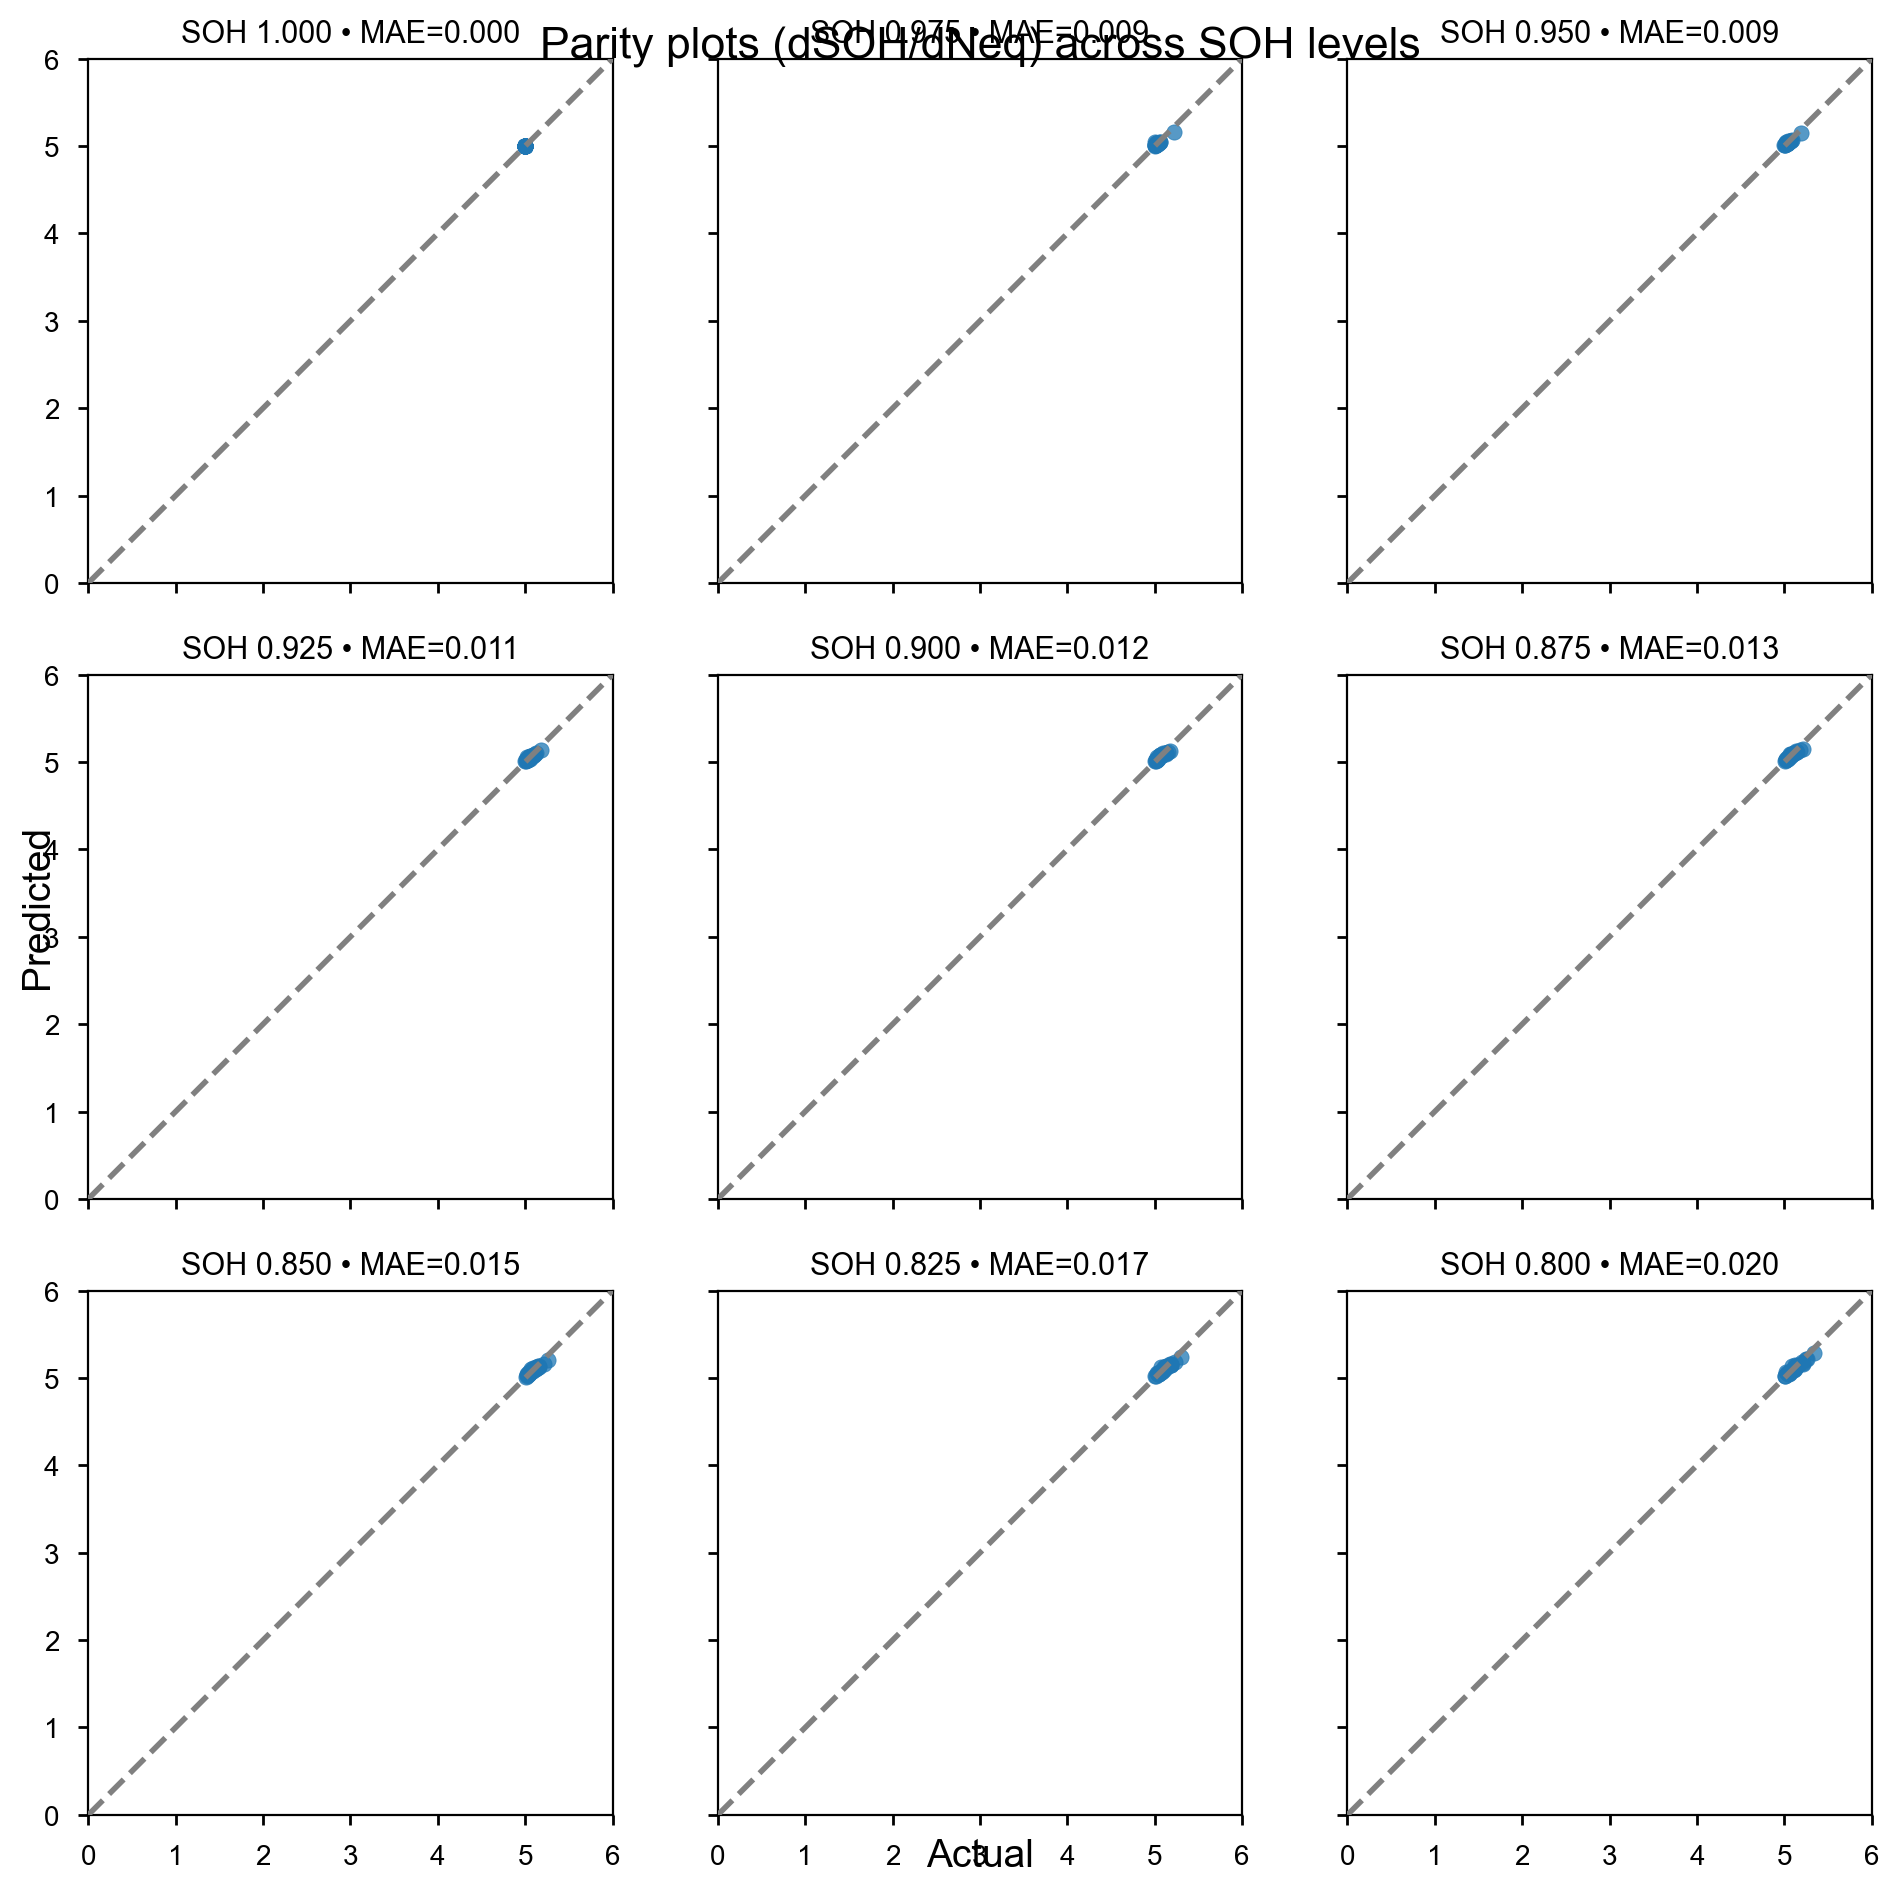

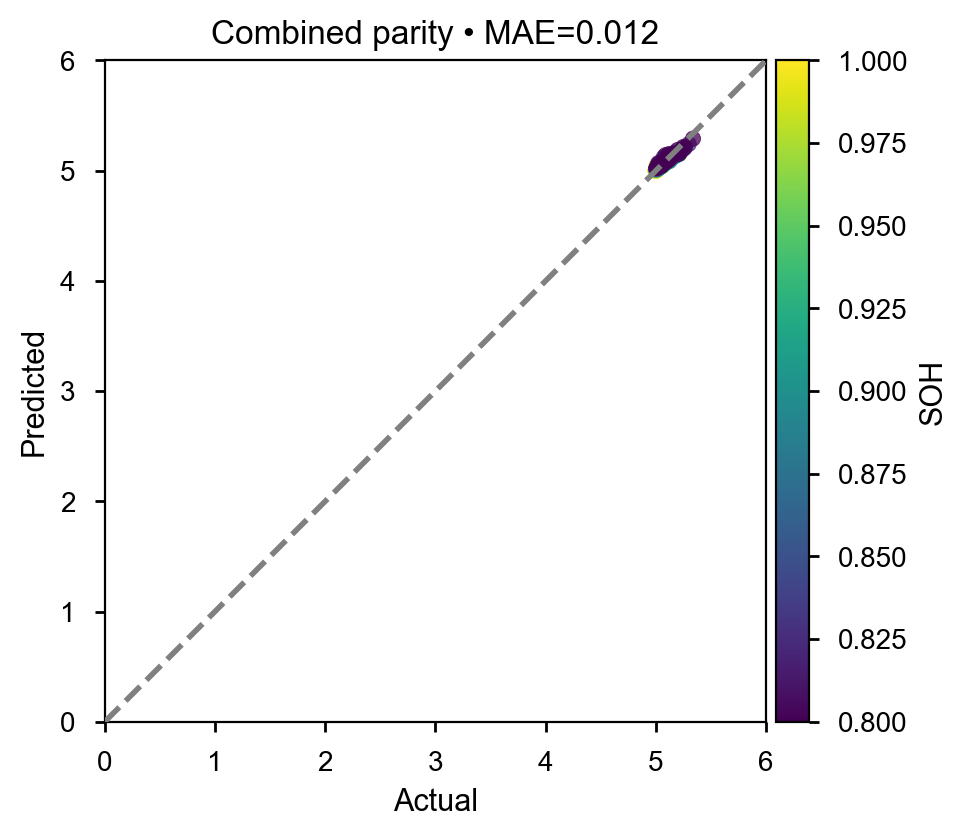

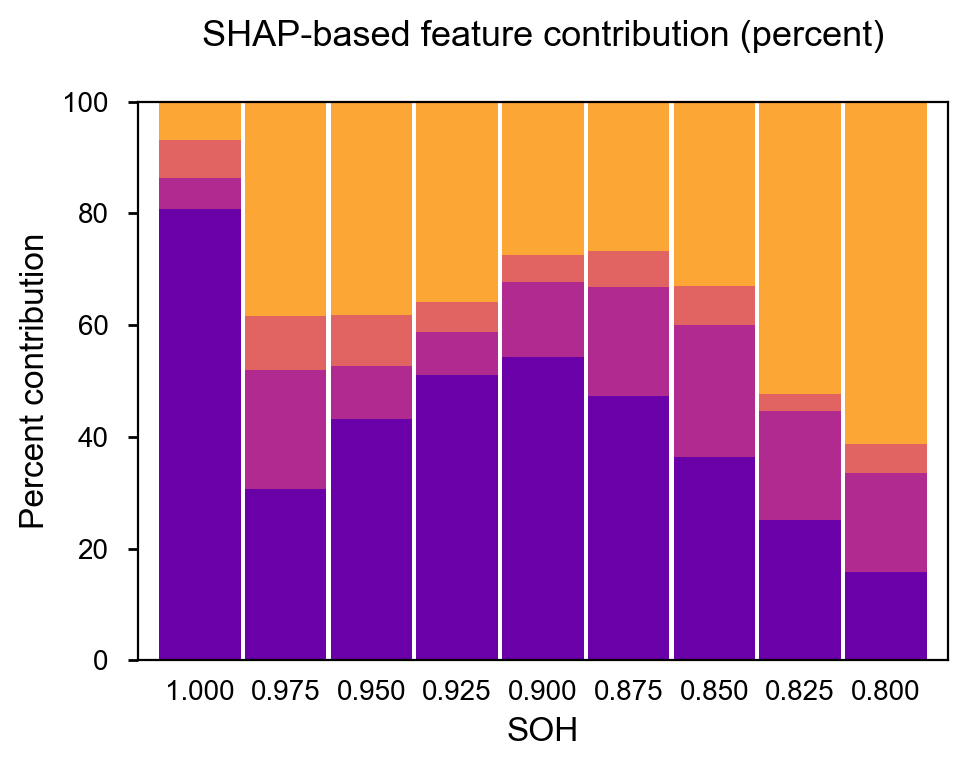

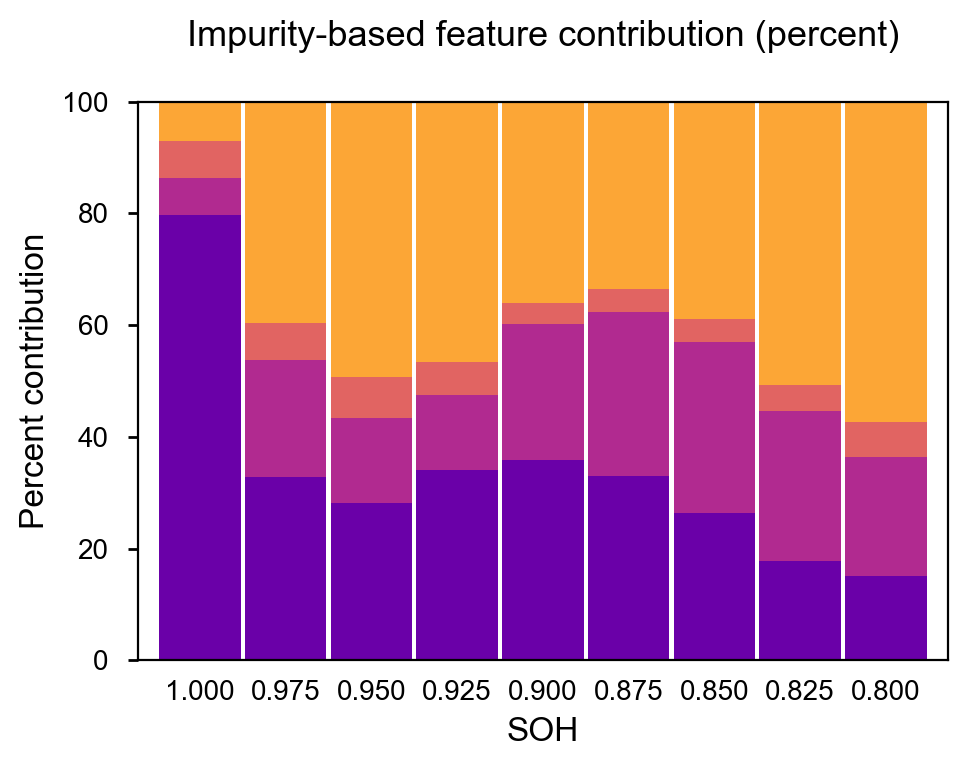

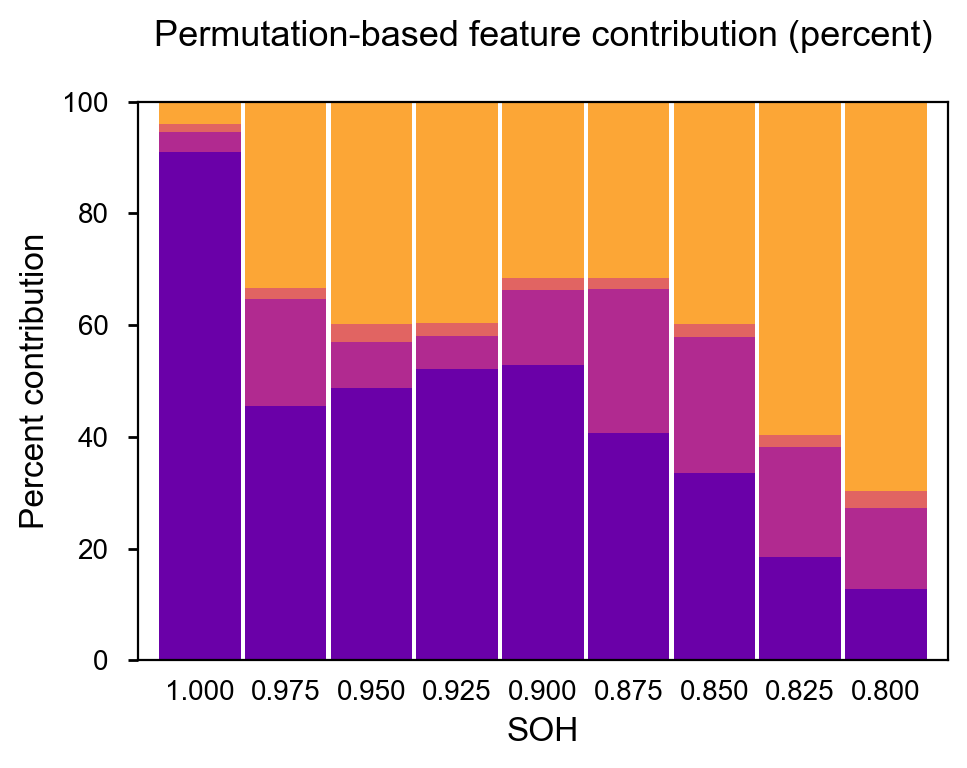

In [ ]:
# === Random Forest Explainer (multi-SOH) ===
from sklearn.ensemble import RandomForestRegressor
from sklearn.inspection import permutation_importance
import shap

FEATURES = ["Ambient temperature", "Discharging current", "Depth of discharge", "Average charging current"]
TARGET = "dSOH/dNeq"

def rf_fit_and_explain(df, soh, random_state=10):
    X, y = df[FEATURES], df[TARGET].astype(float)
    model = RandomForestRegressor(random_state=random_state).fit(X, y)
    y_pred = model.predict(X)

    # Metrics
    mae  = mean_absolute_error(y, y_pred)
    mape = mean_absolute_percentage_error(y, y_pred)

    # Importances
    fi_pct = 100 * model.feature_importances_ / model.feature_importances_.sum()

    explainer = shap.TreeExplainer(model)
    shap_vals = explainer(X).values
    shap_pct = 100 * np.mean(np.abs(shap_vals), axis=0) / np.sum(np.mean(np.abs(shap_vals), axis=0))

    perm = permutation_importance(model, X, y, n_repeats=20, random_state=42, n_jobs=-1)
    perm_pct = 100 * np.abs(perm.importances_mean) / np.sum(np.abs(perm.importances_mean))

    return {"soh": soh, "y_true": y, "y_pred": y_pred, "mae": mae,
            "impurity_pct": pd.Series(fi_pct, index=FEATURES),
            "shap_pct": pd.Series(shap_pct, index=FEATURES),
            "perm_pct": pd.Series(perm_pct, index=FEATURES)}

# Loop over datasets
rf_results = [rf_fit_and_explain(df, soh) for soh, df in soh_to_df.items()]

# === Plotting (same as your orchestration) ===
# -> 3×3 parity plots
# -> Combined parity
# -> Stacked barplots (shap_df, imp_df, perm_df)


# === Orchestrator ===
# Assemble your SOH datasets (already defined by you)
soh_to_df = {
    1.000: SOH_100,
    0.975: SOH_0975,
    0.950: SOH_0950,
    0.925: SOH_0925,
    0.900: SOH_0900,
    0.875: SOH_0875,
    0.850: SOH_0850,
    0.825: SOH_0825,
    0.800: SOH_0800,
}

# Fit all and collect results
results = []
for soh_val in sorted(soh_to_df.keys(), reverse=True):
    df = soh_to_df[soh_val]
    out = fit_and_explain(df, soh_val)
    results.append(out)

# === 3×3 parity plots with MAE annotations ===
# Get global axis limits for parity
all_y_true = np.concatenate([r["y_true"] for r in results])
all_y_pred = np.concatenate([r["y_pred"] for r in results])
max_lim = max(all_y_true.max(), all_y_pred.max())
max_lim = float(np.ceil(max_lim * 20) / 20)  # round up to nearest 0.05
max_lim = max(max_lim, 10)  # at least 0.35 to match prior styling; tweak if you want

fig, axes = plt.subplots(3, 3, figsize=(10, 10), sharex=True, sharey=True)
axes = axes.flatten()

cmap = plt.cm.viridis
norm = plt.Normalize(vmin=min(soh_to_df.keys()), vmax=max(soh_to_df.keys()))

for ax, r in zip(axes, results):
    soh = r["soh"]
    ax.scatter(r["y_true"], r["y_pred"], alpha=0.75, s=30, c='C0')
    add_diagonal(ax, max_lim)
    ax.set_xlim(0, max_lim)
    ax.set_ylim(0, max_lim)
    ax.set_aspect("equal", adjustable="box")
    ax.set_title(f"SOH {soh:.3f} • MAE={r['mae']:.3f}", fontsize=11)

# Hide any unused axes (shouldn't be any for 9)
for i in range(len(results), len(axes)):
    axes[i].axis("off")

fig.suptitle("Parity plots (dSOH/dNeq) across SOH levels", y=0.94, fontsize=16)
fig.text(0.5, 0.02, "Actual", ha="center", fontsize=14)
fig.text(0.02, 0.5, "Predicted", va="center", rotation="vertical", fontsize=14)

# Use subplots_adjust instead of tight_layout for better control
plt.subplots_adjust(left=0.08, right=0.95, top=0.90, bottom=0.08, 
                   wspace=0.05, hspace=0.25)
plt.show()

# === Final combined parity plot (colored by SOH) ===
fig, ax = plt.subplots(figsize=(5, 5))
for r in results:
    soh = r["soh"]
    clr = cmap(norm(soh))
    ax.scatter(r["y_true"], r["y_pred"], alpha=0.75, s=30, c=[clr]*len(r["y_pred"]))

add_diagonal(ax, max_lim)
ax.set_xlim(0, max_lim)
ax.set_ylim(0, max_lim)
ax.set_aspect("equal", adjustable="box")
ax.set_xlabel("Actual")
ax.set_ylabel("Predicted")
overall_mae = mean_absolute_error(all_y_true, all_y_pred)
ax.set_title(f"Combined parity • MAE={overall_mae:.3f}")

# Attach a colorbar axis with exactly the same height as the main axes
divider = make_axes_locatable(ax)
cax = divider.append_axes("right", size="5%", pad=0.05)
mappable = plt.cm.ScalarMappable(norm=norm, cmap=cmap)
cbar = plt.colorbar(mappable, cax=cax)
cbar.set_label("SOH")

plt.tight_layout()
plt.show()

# === CONSISTENT STACKED BAR PLOTS ===
# Create the dataframes for plotting
shap_df = percent_df(results, "shap_pct")
imp_df = percent_df(results, "impurity_pct")  
perm_df = percent_df(results, "perm_pct")

# Consistent settings for ALL plots
FIGSIZE_STACKED = (5, 4)  # Slightly larger to prevent overlapping
YLIM_STACKED = (0, 100)
feature_colors = sns.color_palette("plasma", n_colors=len(FEATURES))

def stacked_bar(df, title, ylabel="Percent contribution", show_legend=True, savepath=None):
    """Create consistent stacked bar plots with identical styling."""
    # Create fig/ax explicitly so figsize is guaranteed identical
    fig, ax = plt.subplots(figsize=FIGSIZE_STACKED)
    df.plot.bar(stacked=True, color=feature_colors, width=0.95, ax=ax)

    ax.set_xlabel("SOH", fontsize=12)
    ax.set_ylabel(ylabel, fontsize=12)
    ax.set_title(title, fontsize=13, pad=20)  # Add padding to prevent overlap
    ax.set_xticklabels([f"{idx:.3f}" for idx in df.index], rotation=0)
    ax.tick_params(axis='x', which='both', length=0)
    ax.set_ylim(*YLIM_STACKED)

    # Consistent legend handling
    if show_legend:
        ax.legend(loc='upper left', bbox_to_anchor=(1.02, 1), title='Features', 
                 frameon=False, fontsize=10, title_fontsize=11)
    else:
        # Remove legend completely
        if ax.legend_:
            ax.legend_.remove()

    # Use subplots_adjust instead of tight_layout for better control
    plt.subplots_adjust(left=0.12, right=0.85 if show_legend else 0.95, 
                       top=0.85, bottom=0.15)
    
    if savepath:
        fig.savefig(savepath, dpi=300, bbox_inches="tight")
    plt.show()

# Create all three plots with identical styling
stacked_bar(shap_df, "SHAP-based feature contribution (percent)", show_legend=False)
stacked_bar(imp_df, "Impurity-based feature contribution (percent)", show_legend=False)
stacked_bar(perm_df, "Permutation-based feature contribution (percent)", show_legend=False)

### Random Forest Regression

In [ ]:
def rf_explainer(X, y, feature_names=None):
    from sklearn.ensemble import RandomForestRegressor
    from sklearn.inspection import permutation_importance
    import shap, matplotlib.pyplot as plt
    import numpy as np

    # MODEL
    model = RandomForestRegressor(n_estimators=200, max_depth=6, random_state=42)
    model.fit(X, y)
    y_pred = model.predict(X)

    # SHAP
    expl = shap.TreeExplainer(model)
    shap_vals = expl(X)
    shap_abs_mean = np.abs(shap_vals.values).mean(0)

    # PERMUTATION
    pi = permutation_importance(model, X, y, n_repeats=20, random_state=42)
    perm_mean = pi.importances_mean

    # IMPURITY
    impurity = model.feature_importances_

    # ===========================
    # FIGURES
    # ===========================

    ## 1. 3×3 Parity Grid
    gids = np.digitize(y_pred, np.percentile(y_pred, np.linspace(0,100,10))[1:-1])
    fig, axes = plt.subplots(3,3,figsize=(9,9), constrained_layout=True)
    axes = axes.ravel()
    for i in range(9):
        ax = axes[i]
        mask = (gids==i)
        if not np.any(mask):
            ax.axis("off"); continue
        ax.scatter(y[mask], y_pred[mask], s=10, alpha=0.7)
        ax.plot([y.min(), y.max()],[y.min(), y.max()],'k--')
        ax.set_title(f"Bin {i+1}")
        ax.set_xlabel("Actual"); ax.set_ylabel("Predicted")
        ax.set_aspect("equal","box")
    fig.suptitle("Random Forest: 3×3 Parity Grid")
    plt.show()

    ## 2. Combined Parity Plot
    fig, ax = plt.subplots(figsize=(6,6))
    scatter = ax.scatter(y, y_pred, c=gids, cmap="tab10", s=20, alpha=0.8)
    ax.plot([y.min(), y.max()],[y.min(), y.max()],'k--')
    ax.set_aspect("equal","box")
    ax.set_xlabel("Actual"); ax.set_ylabel("Predicted")
    ax.set_title("Random Forest: Combined Parity")
    plt.colorbar(scatter, ax=ax, label="Bin")
    plt.show()

    ## 3. SHAP FI Plot
    fig, ax = plt.subplots(figsize=(5,4))
    ax.barh(feature_names, shap_abs_mean)
    ax.set_title("SHAP Importance")
    plt.show()

    ## 4. Permutation FI Plot
    fig, ax = plt.subplots(figsize=(5,4))
    ax.barh(feature_names, perm_mean)
    ax.set_title("Permutation Importance")
    plt.show()

    ## 5. Impurity FI Plot
    fig, ax = plt.subplots(figsize=(5,4))
    ax.barh(feature_names, impurity)
    ax.set_title("Impurity Importance")
    plt.show()

    return model, y_pred, shap_abs_mean, perm_mean, impurity


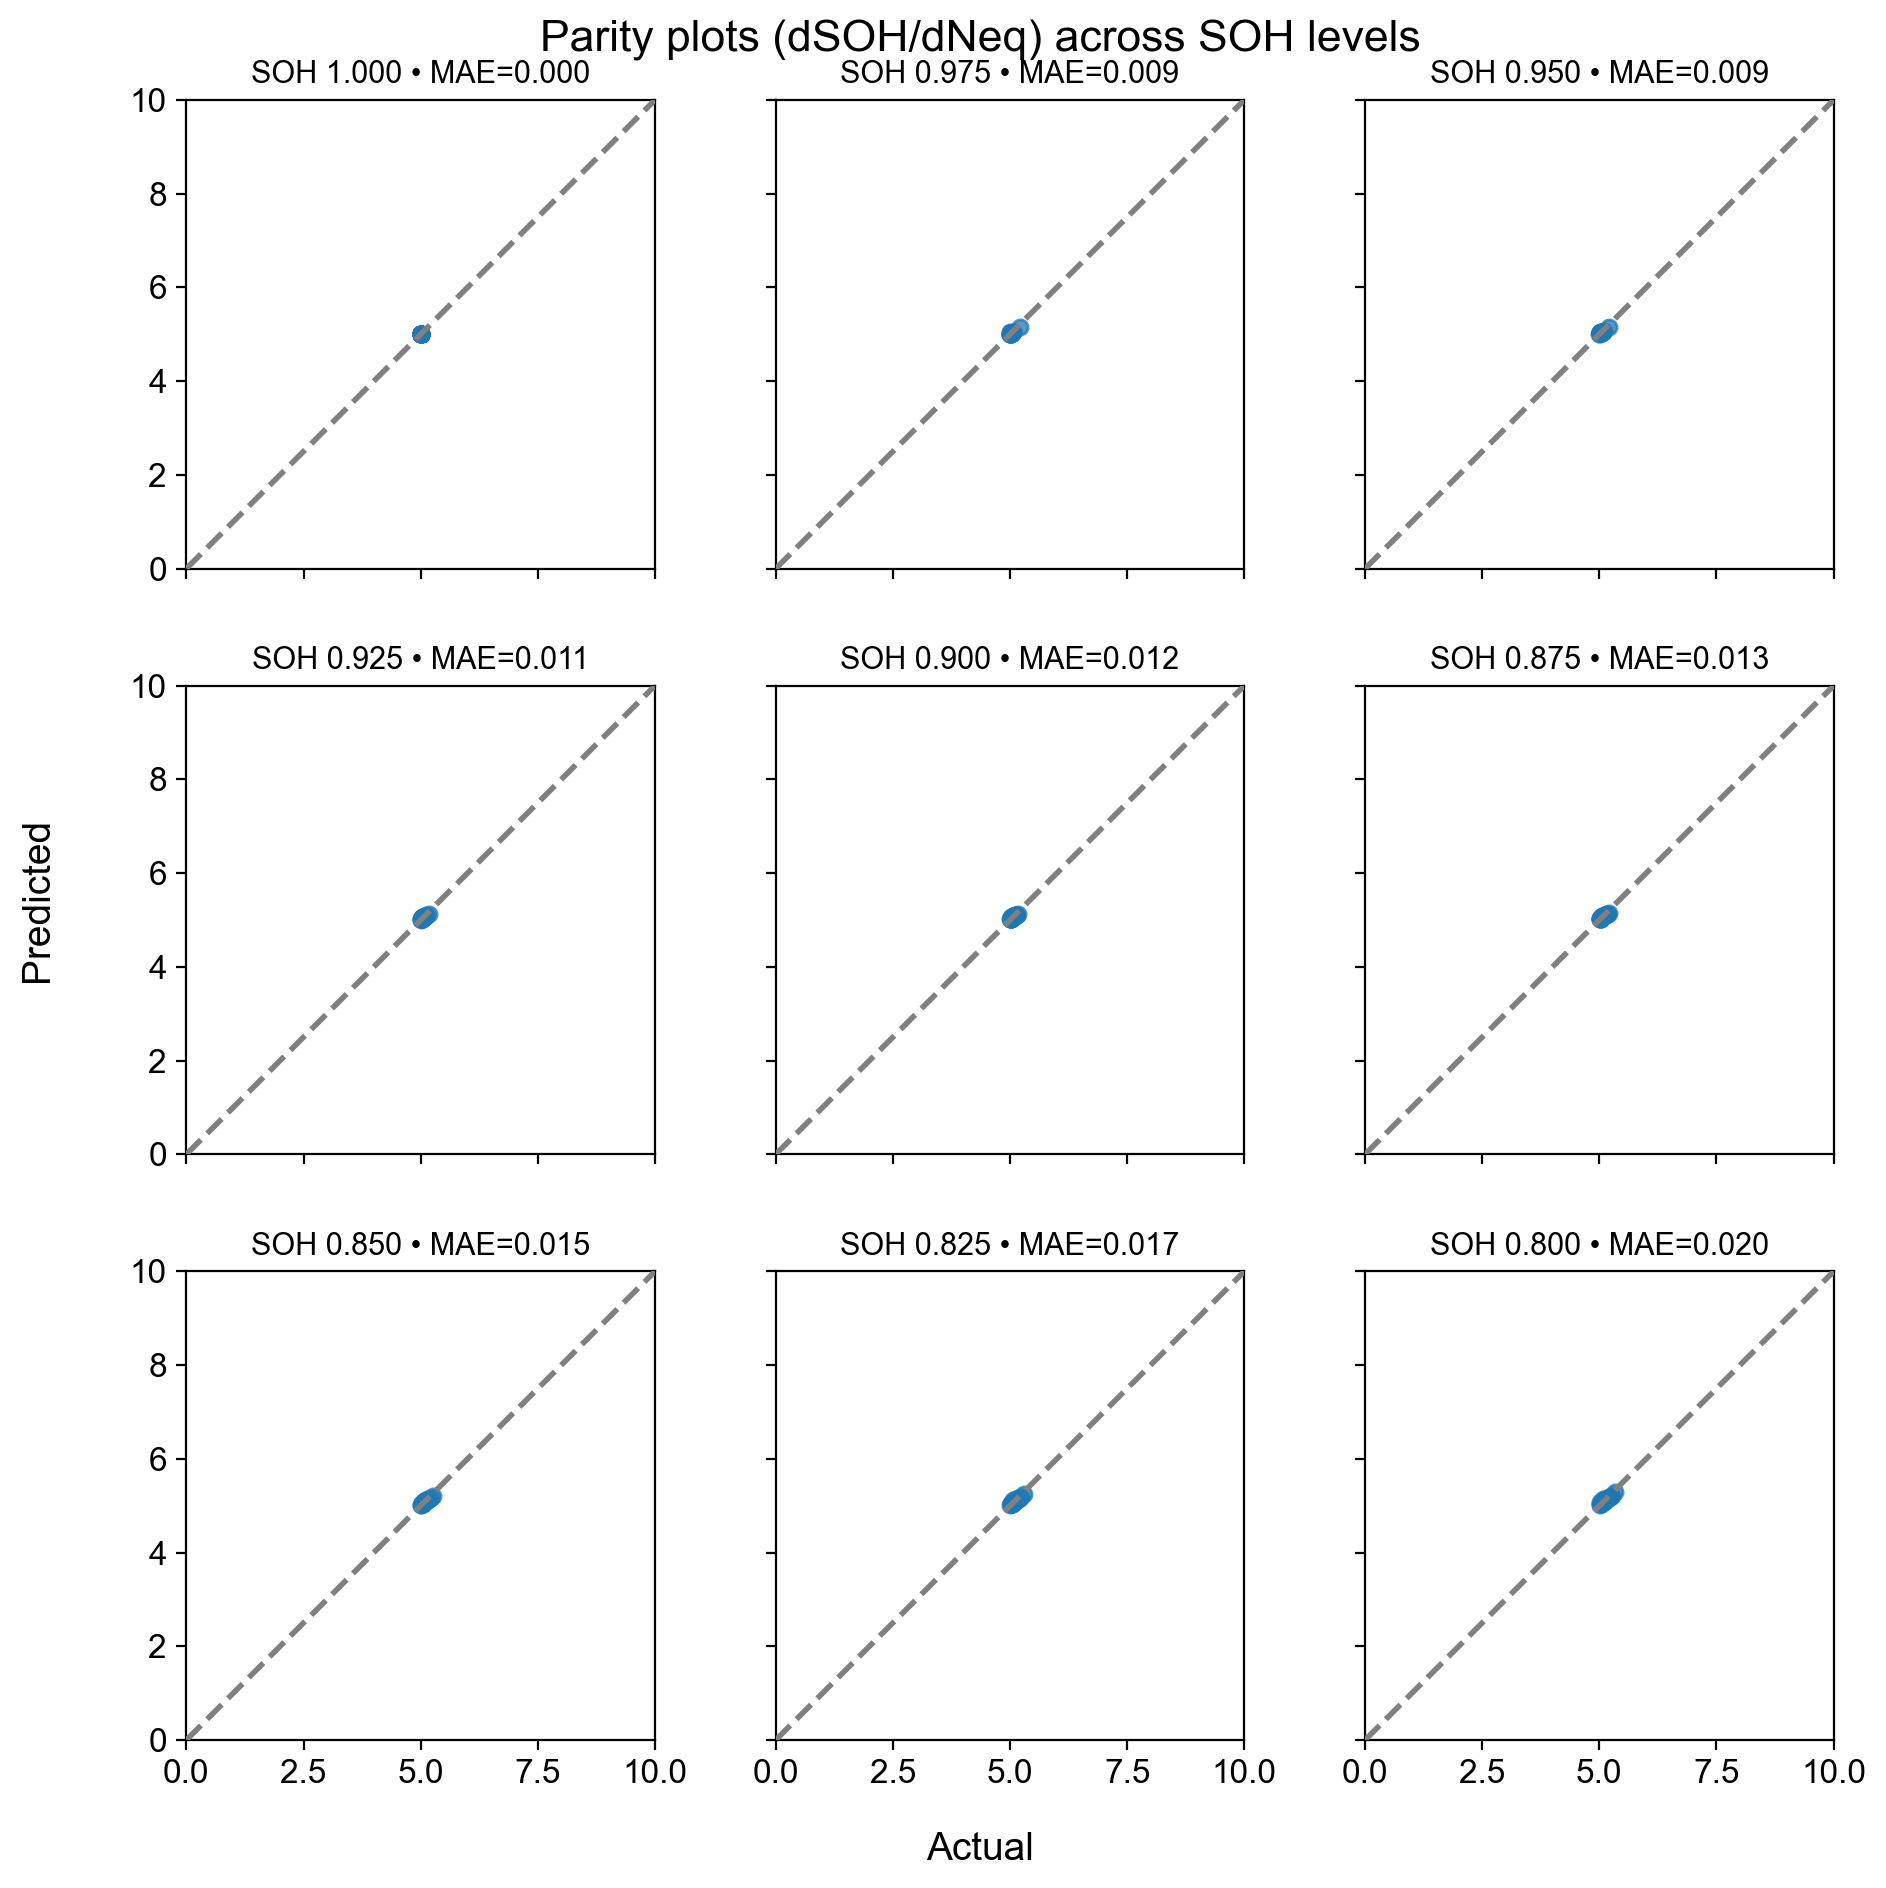

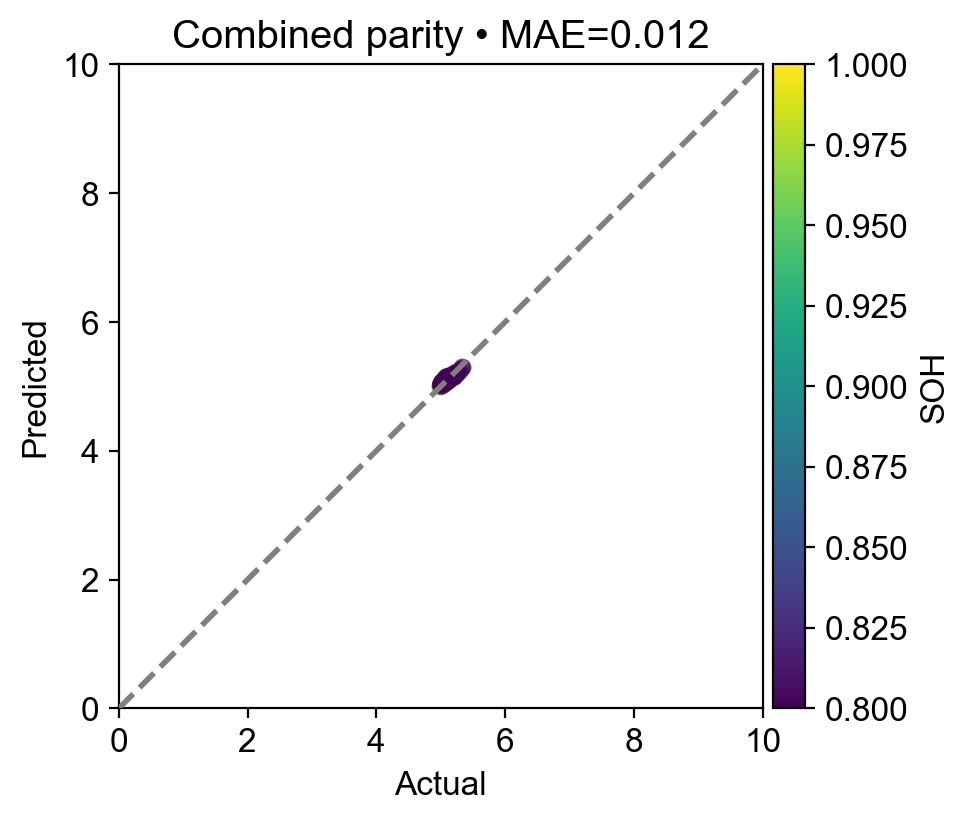

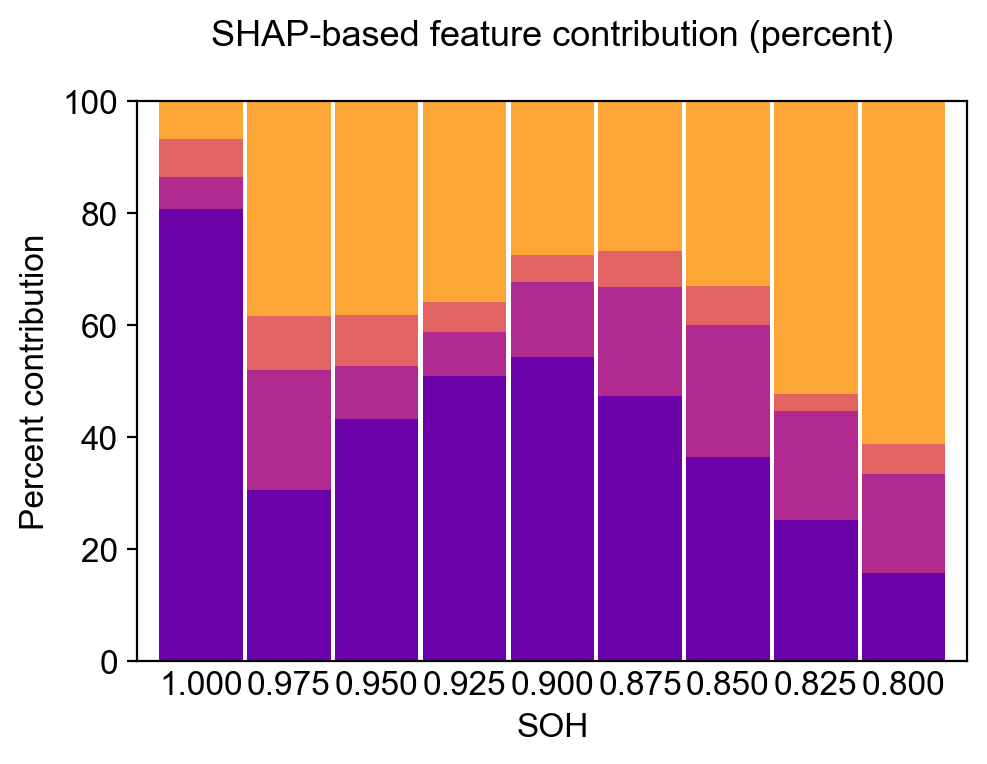

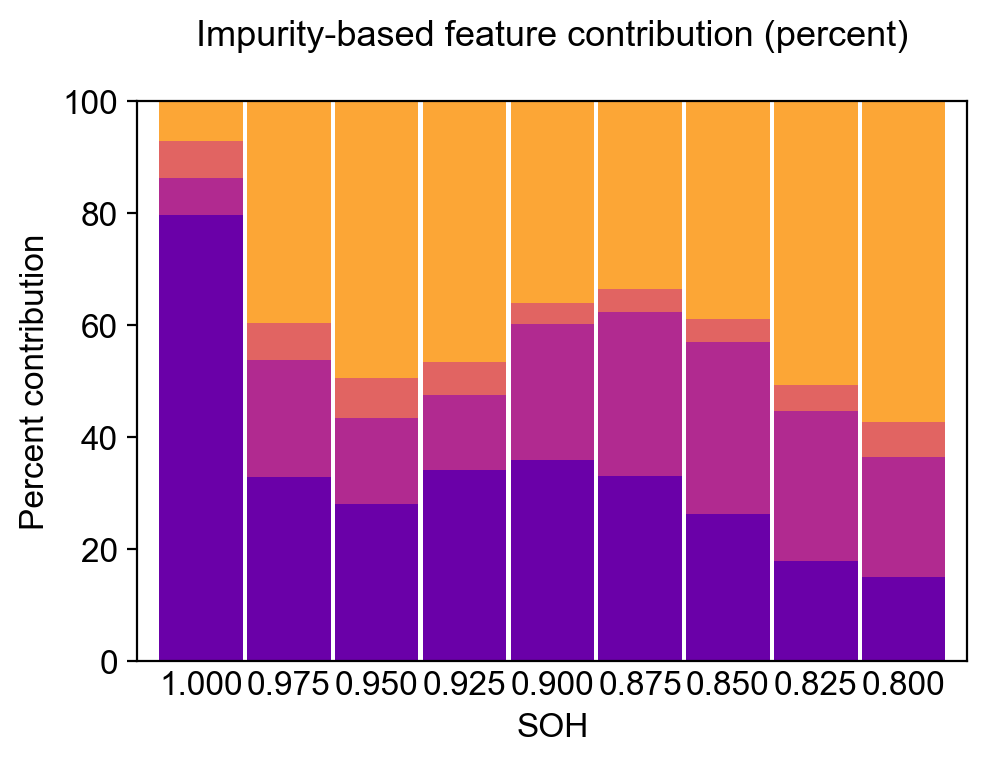

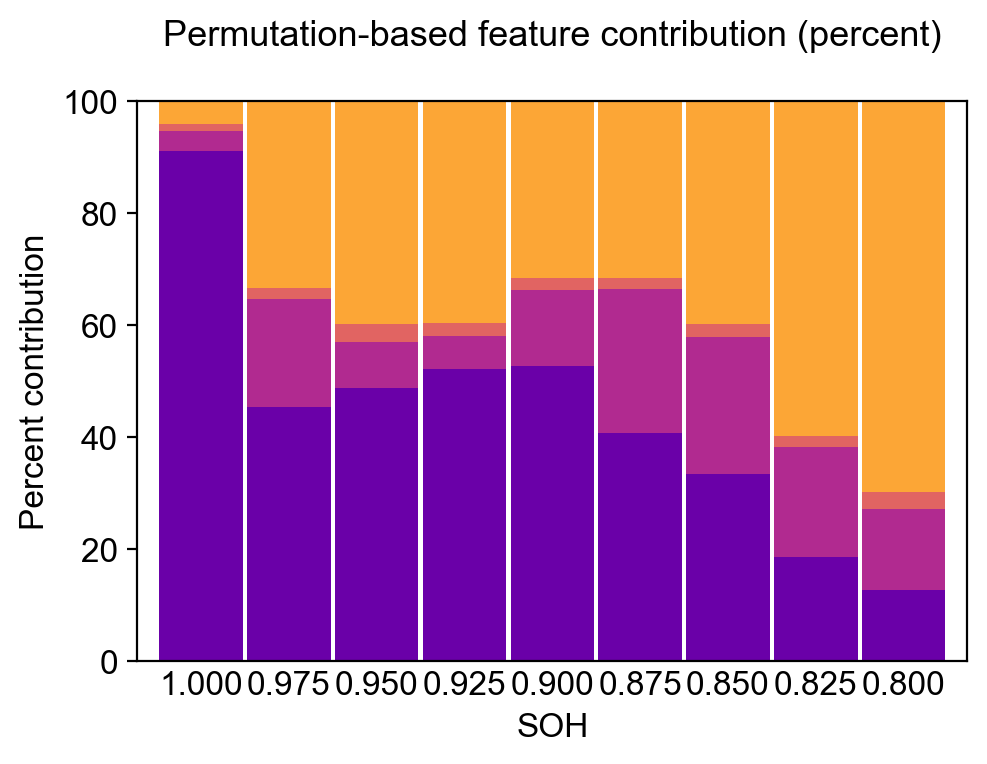

In [238]:
plt.rcParamsDefault
sns.reset_defaults()
plt.rcParams['font.sans-serif'] = 'Arial'
plt.rcParams['font.size'] = 12

# === Helpers ===
FEATURES = ["Ambient temperature", "Discharging current", "Depth of discharge", "Average charging current"]
TARGET = "dSOH/dNeq"

def fit_and_explain(df: pd.DataFrame, soh_value: float, random_state: int = 10):
    """Fit RF, compute predictions & metrics, impurity %, SHAP abs-mean, and permutation %."""
    X = df[FEATURES].copy()
    y = df[TARGET].astype(float).copy()

    model = RandomForestRegressor(random_state=random_state)
    model.fit(X, y)
    y_pred = model.predict(X)

    mae  = mean_absolute_error(y, y_pred)
    mape = mean_absolute_percentage_error(y, y_pred)

    # # (Optional) cross-val—kept light; comment out if you don't need it
    # try:
    #     cv_mae = -cross_val_score(model, X, y, cv=5, scoring="neg_mean_absolute_error", n_jobs=-1)
    # except Exception:
    #     cv_mae = None

    # Impurity -> % (sums to 100)
    fi_raw = np.asarray(model.feature_importances_, dtype=float)
    fi_pct = 100.0 * fi_raw / fi_raw.sum() if fi_raw.sum() > 0 else np.zeros_like(fi_raw)

    # SHAP abs-mean (TreeExplainer); robust to different SHAP returns
    explainer = shap.TreeExplainer(model)
    shap_expl = explainer(X)  # Explanation object in recent SHAP versions
    if hasattr(shap_expl, "values"):
        shap_vals = shap_expl.values
    else:
        shap_vals = shap_expl  # fallback

    shap_abs_mean = np.mean(np.abs(shap_vals), axis=0)
    shap_pct = 100.0 * shap_abs_mean / shap_abs_mean.sum() if shap_abs_mean.sum() > 0 else np.zeros_like(shap_abs_mean)

    # Permutation importance -> % of |mean| normalized
    perm = permutation_importance(model, X, y, n_repeats=20, random_state=42, n_jobs=-1)
    perm_mean = np.asarray(perm.importances_mean, dtype=float)
    denom = np.sum(np.abs(perm_mean))
    perm_pct = 100.0 * np.abs(perm_mean) / denom if denom > 0 else np.zeros_like(perm_mean)

    return {
        "soh": soh_value,
        "y_true": y.values,
        "y_pred": y_pred,
        "mae": mae,
        "mape": mape,
        # "cv_mae": cv_mae,  # may be None
        "impurity_pct": pd.Series(fi_pct, index=FEATURES),
        "shap_pct":     pd.Series(shap_pct, index=FEATURES),
        "perm_pct":     pd.Series(perm_pct, index=FEATURES),
    }

def percent_df(rows, key, index_name="SOH"):
    """Build a DF: rows keyed by SOH, columns=FEATURES, values are percentages."""
    df = pd.DataFrame({r["soh"]: r[key] for r in rows}).T
    df.index.name = index_name
    return df.loc[sorted(df.index, reverse=True)]  # sort SOH 1.0 -> 0.8

def add_diagonal(ax, lim):
    ax.plot([0, lim], [0, lim], ls="--", lw=2, color="grey", zorder=3)

# === Orchestrator ===
# Assemble your SOH datasets (already defined by you)
soh_to_df = {
    1.000: SOH_100,
    0.975: SOH_0975,
    0.950: SOH_0950,
    0.925: SOH_0925,
    0.900: SOH_0900,
    0.875: SOH_0875,
    0.850: SOH_0850,
    0.825: SOH_0825,
    0.800: SOH_0800,
}

# Fit all and collect results
results = []
for soh_val in sorted(soh_to_df.keys(), reverse=True):
    df = soh_to_df[soh_val]
    out = fit_and_explain(df, soh_val)
    results.append(out)

# === 3×3 parity plots with MAE annotations ===
# Get global axis limits for parity
all_y_true = np.concatenate([r["y_true"] for r in results])
all_y_pred = np.concatenate([r["y_pred"] for r in results])
max_lim = max(all_y_true.max(), all_y_pred.max())
max_lim = float(np.ceil(max_lim * 20) / 20)  # round up to nearest 0.05
max_lim = max(max_lim, 10)  # at least 0.35 to match prior styling; tweak if you want

fig, axes = plt.subplots(3, 3, figsize=(10, 10), sharex=True, sharey=True)
axes = axes.flatten()

cmap = plt.cm.viridis
norm = plt.Normalize(vmin=min(soh_to_df.keys()), vmax=max(soh_to_df.keys()))

for ax, r in zip(axes, results):
    soh = r["soh"]
    ax.scatter(r["y_true"], r["y_pred"], alpha=0.75, s=30, c='C0')
    add_diagonal(ax, max_lim)
    ax.set_xlim(0, max_lim)
    ax.set_ylim(0, max_lim)
    ax.set_aspect("equal", adjustable="box")
    ax.set_title(f"SOH {soh:.3f} • MAE={r['mae']:.3f}", fontsize=11)

# Hide any unused axes (shouldn't be any for 9)
for i in range(len(results), len(axes)):
    axes[i].axis("off")

fig.suptitle("Parity plots (dSOH/dNeq) across SOH levels", y=0.94, fontsize=16)
fig.text(0.5, 0.02, "Actual", ha="center", fontsize=14)
fig.text(0.02, 0.5, "Predicted", va="center", rotation="vertical", fontsize=14)

# Use subplots_adjust instead of tight_layout for better control
plt.subplots_adjust(left=0.08, right=0.95, top=0.90, bottom=0.08, 
                   wspace=0.05, hspace=0.25)
plt.show()

# === Final combined parity plot (colored by SOH) ===
fig, ax = plt.subplots(figsize=(5, 5))
for r in results:
    soh = r["soh"]
    clr = cmap(norm(soh))
    ax.scatter(r["y_true"], r["y_pred"], alpha=0.75, s=30, c=[clr]*len(r["y_pred"]))

add_diagonal(ax, max_lim)
ax.set_xlim(0, max_lim)
ax.set_ylim(0, max_lim)
ax.set_aspect("equal", adjustable="box")
ax.set_xlabel("Actual")
ax.set_ylabel("Predicted")
overall_mae = mean_absolute_error(all_y_true, all_y_pred)
ax.set_title(f"Combined parity • MAE={overall_mae:.3f}")

# Attach a colorbar axis with exactly the same height as the main axes
divider = make_axes_locatable(ax)
cax = divider.append_axes("right", size="5%", pad=0.05)
mappable = plt.cm.ScalarMappable(norm=norm, cmap=cmap)
cbar = plt.colorbar(mappable, cax=cax)
cbar.set_label("SOH")

plt.tight_layout()
plt.show()

# === CONSISTENT STACKED BAR PLOTS ===
# Create the dataframes for plotting
shap_df = percent_df(results, "shap_pct")
imp_df = percent_df(results, "impurity_pct")  
perm_df = percent_df(results, "perm_pct")

# Consistent settings for ALL plots
FIGSIZE_STACKED = (5, 4)  # Slightly larger to prevent overlapping
YLIM_STACKED = (0, 100)
feature_colors = sns.color_palette("plasma", n_colors=len(FEATURES))

def stacked_bar(df, title, ylabel="Percent contribution", show_legend=True, savepath=None):
    """Create consistent stacked bar plots with identical styling."""
    # Create fig/ax explicitly so figsize is guaranteed identical
    fig, ax = plt.subplots(figsize=FIGSIZE_STACKED)
    df.plot.bar(stacked=True, color=feature_colors, width=0.95, ax=ax)

    ax.set_xlabel("SOH", fontsize=12)
    ax.set_ylabel(ylabel, fontsize=12)
    ax.set_title(title, fontsize=13, pad=20)  # Add padding to prevent overlap
    ax.set_xticklabels([f"{idx:.3f}" for idx in df.index], rotation=0)
    ax.tick_params(axis='x', which='both', length=0)
    ax.set_ylim(*YLIM_STACKED)

    # Consistent legend handling
    if show_legend:
        ax.legend(loc='upper left', bbox_to_anchor=(1.02, 1), title='Features', 
                 frameon=False, fontsize=10, title_fontsize=11)
    else:
        # Remove legend completely
        if ax.legend_:
            ax.legend_.remove()

    # Use subplots_adjust instead of tight_layout for better control
    plt.subplots_adjust(left=0.12, right=0.85 if show_legend else 0.95, 
                       top=0.85, bottom=0.15)
    
    if savepath:
        fig.savefig(savepath, dpi=300, bbox_inches="tight")
    plt.show()

# Create all three plots with identical styling
stacked_bar(shap_df, "SHAP-based feature contribution (percent)", show_legend=False)
stacked_bar(imp_df, "Impurity-based feature contribution (percent)", show_legend=False)
stacked_bar(perm_df, "Permutation-based feature contribution (percent)", show_legend=False)

### Linear Regression

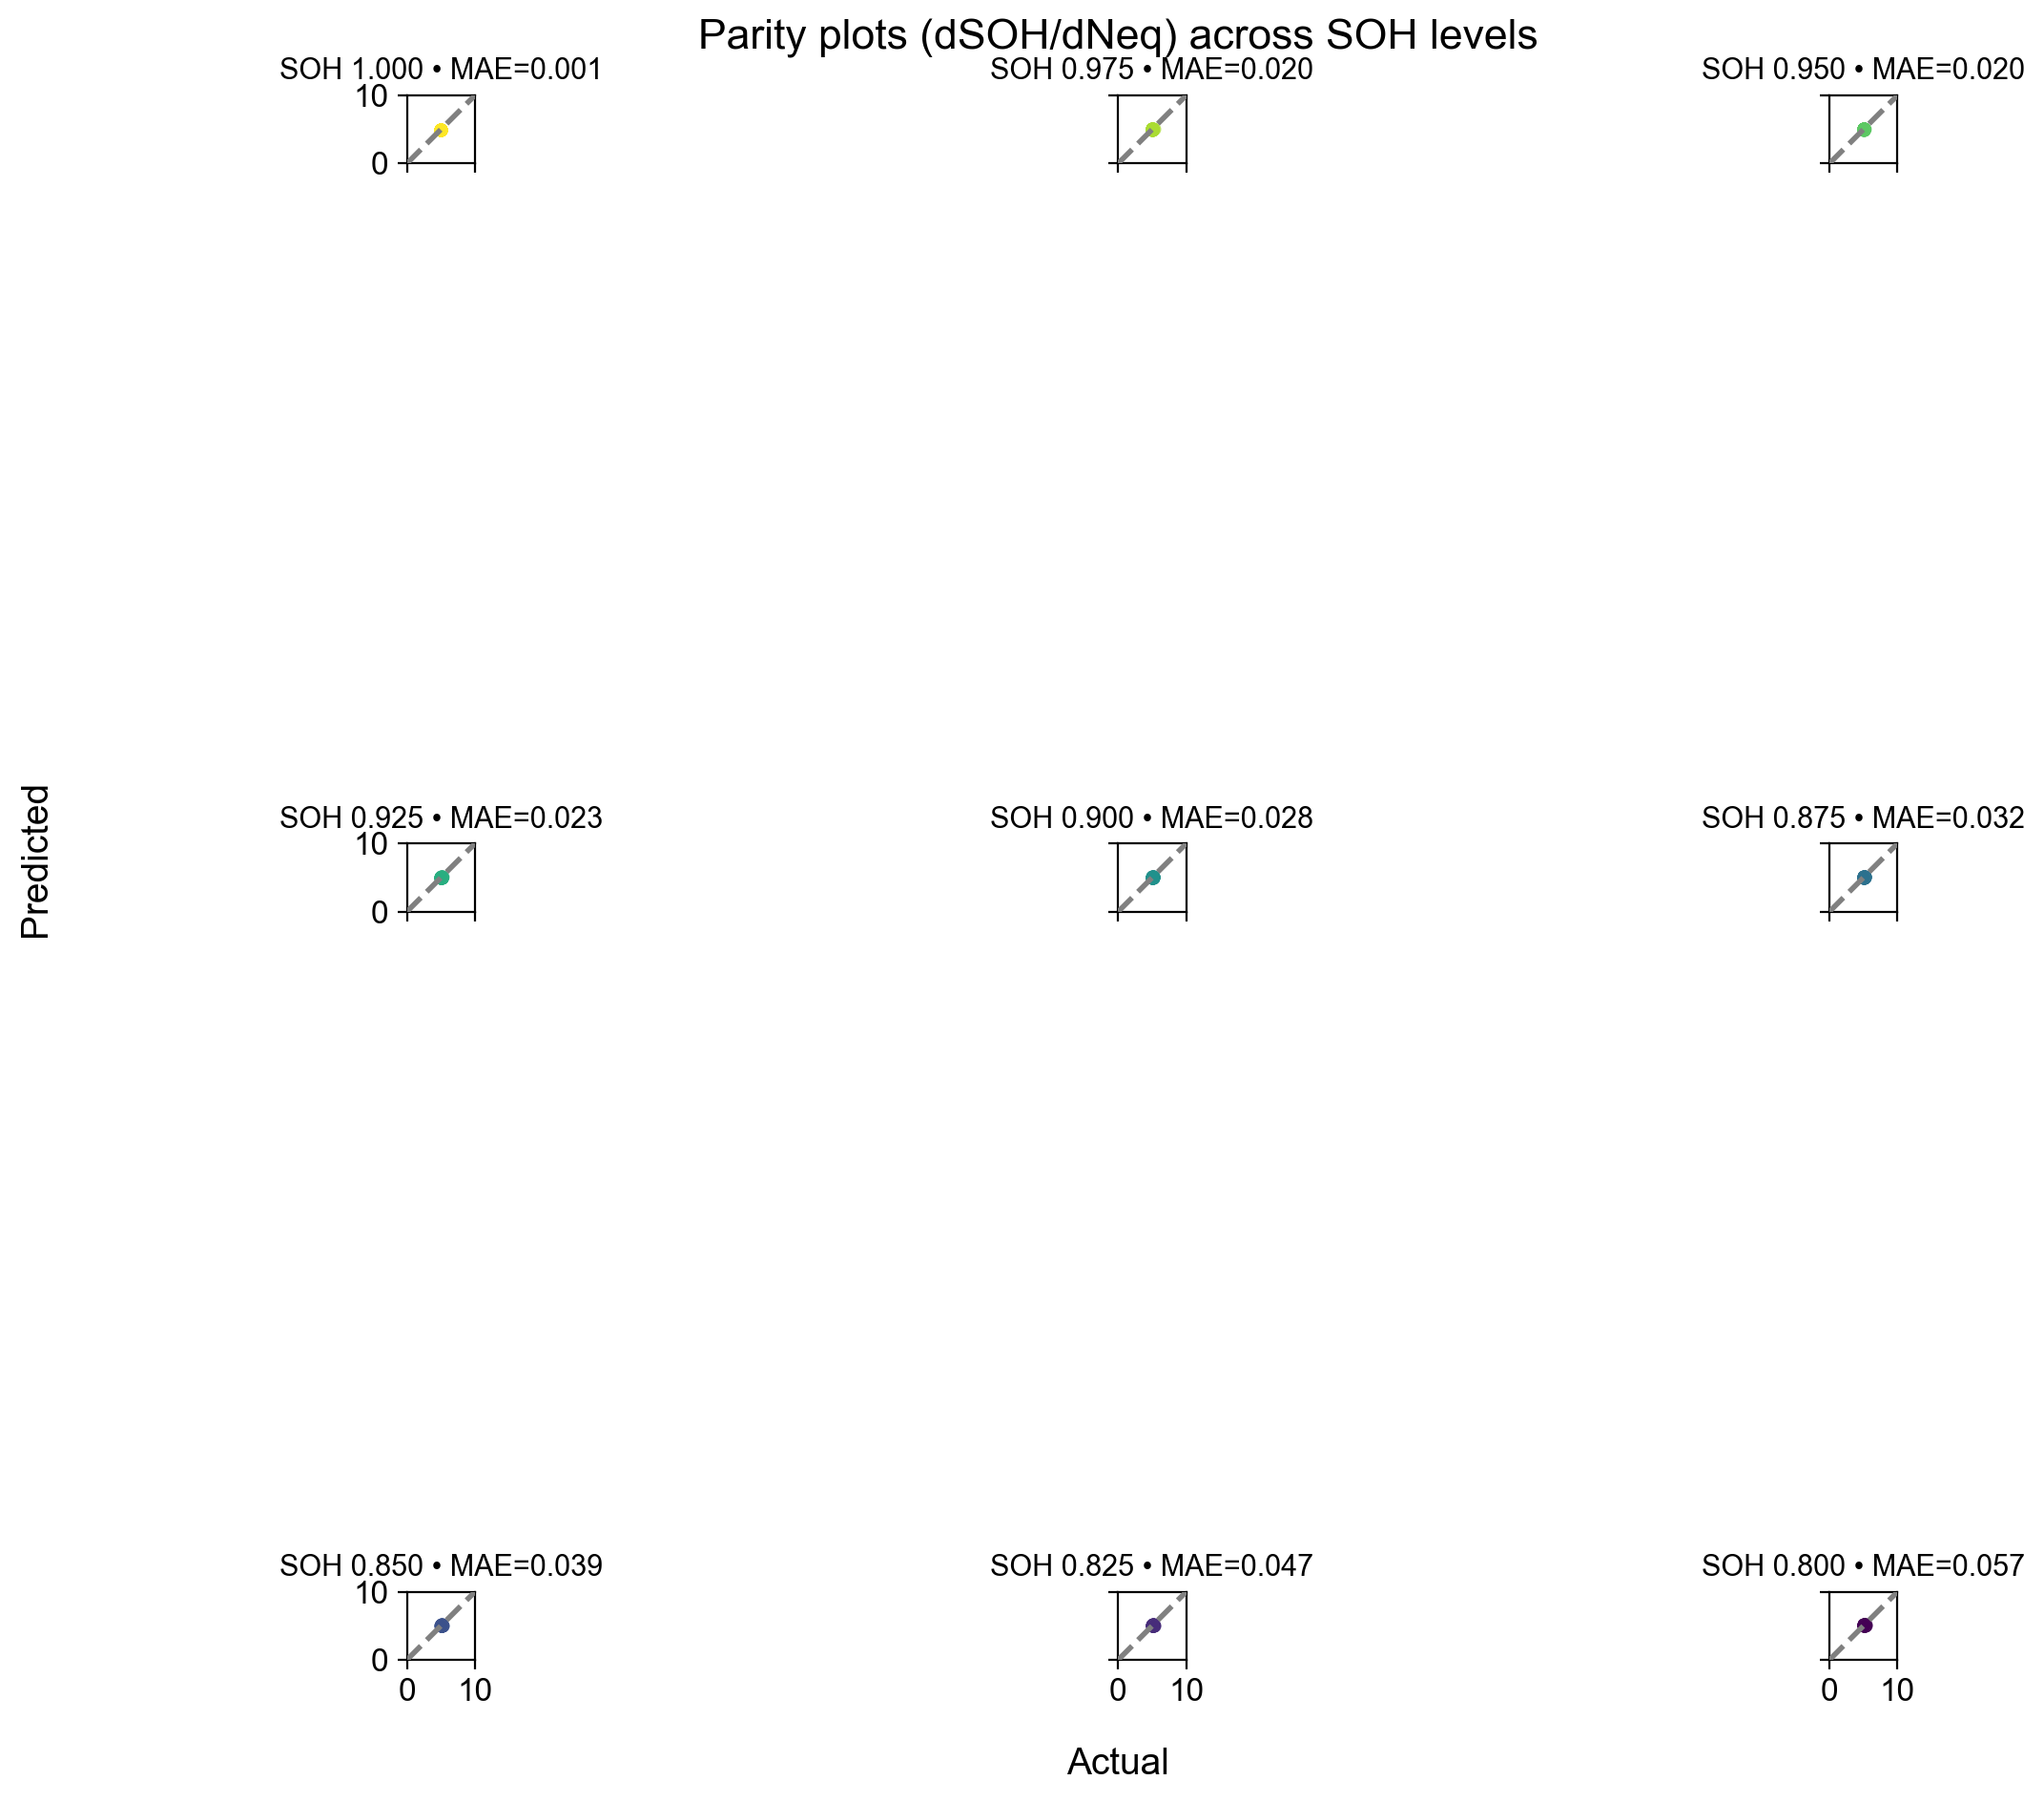

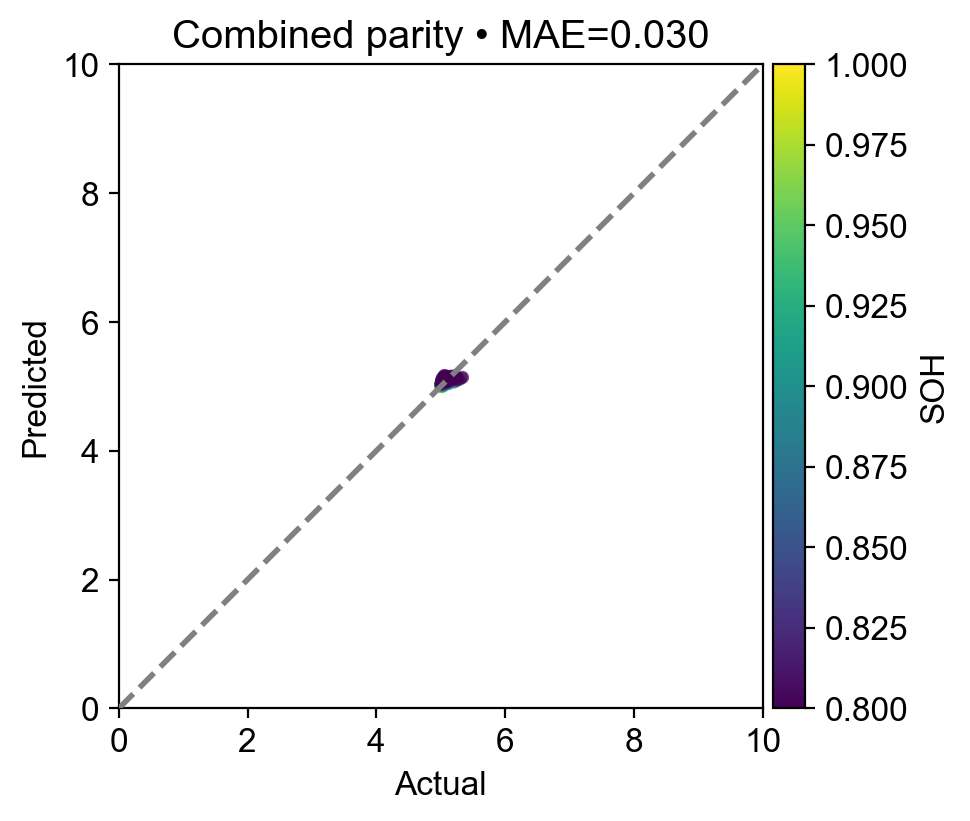

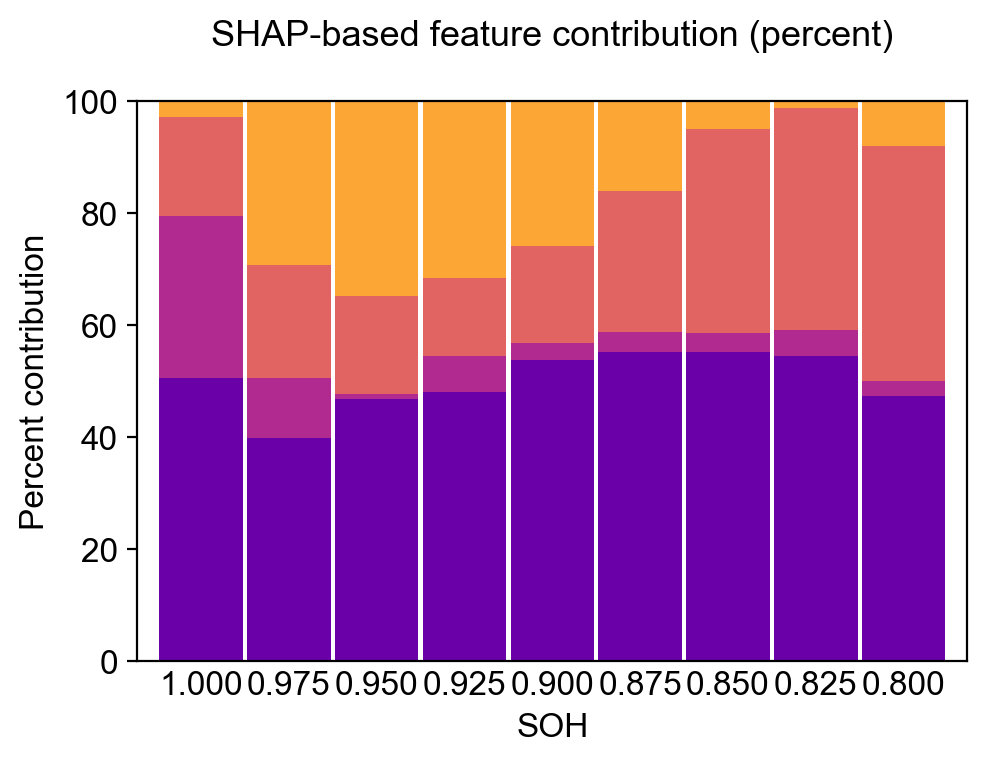

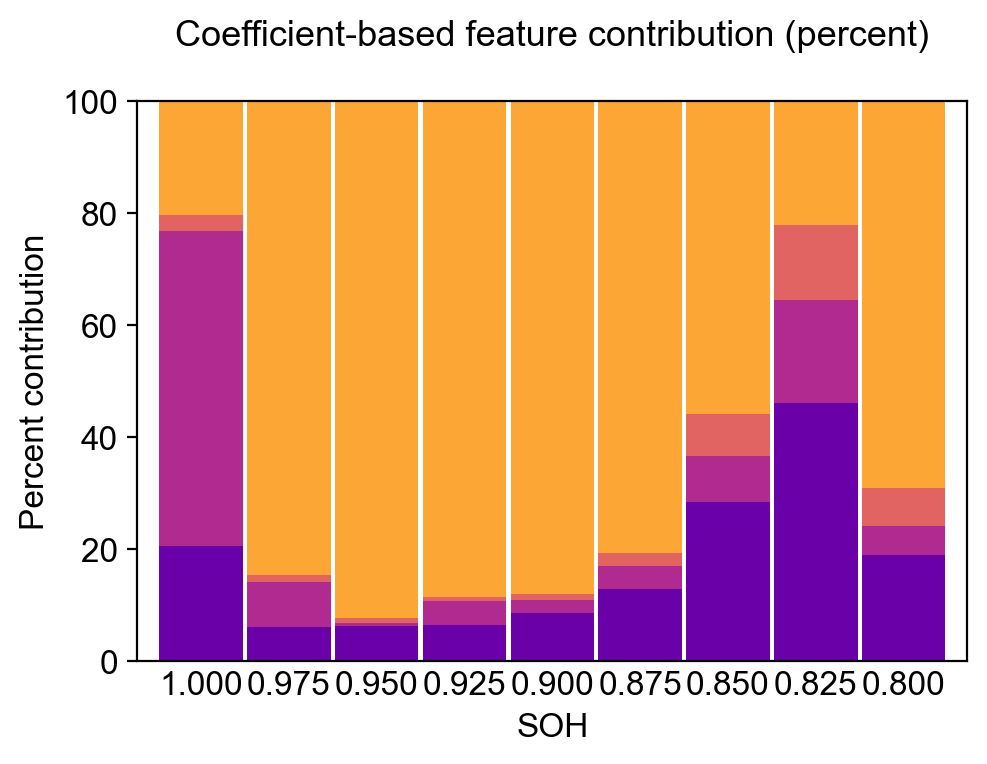

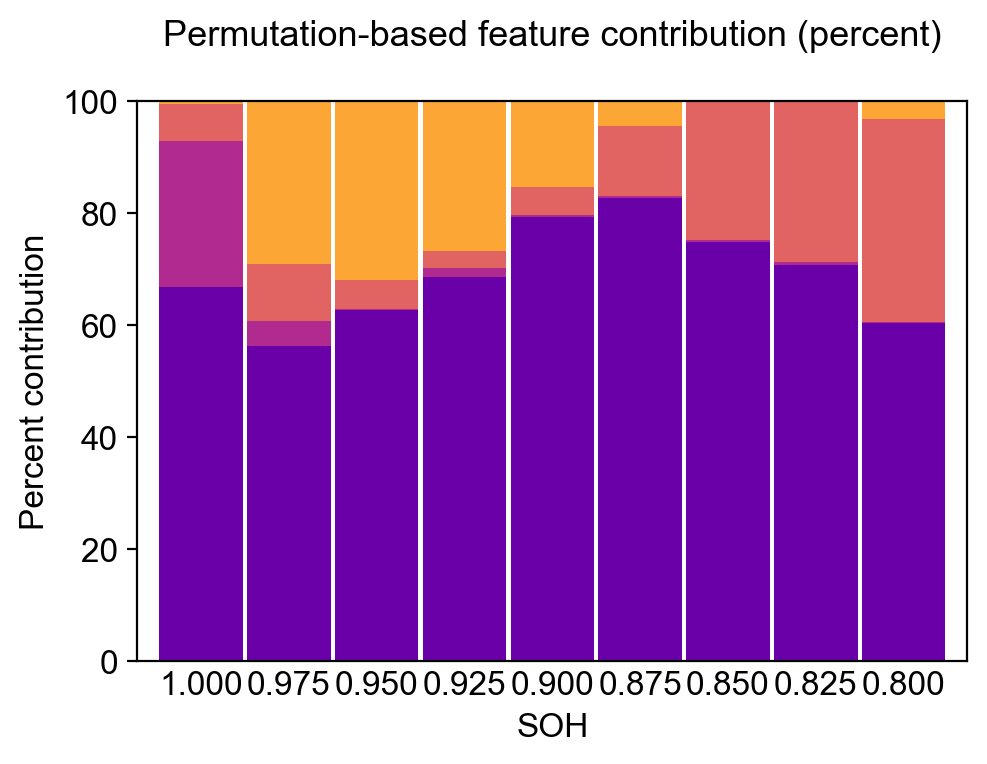

In [177]:
plt.rcParamsDefault
sns.reset_defaults()
plt.rcParams['font.sans-serif'] = 'Arial'
plt.rcParams['font.size'] = 12

# === Helpers ===
FEATURES = ["Ambient temperature", "Discharging current", "Depth of discharge", "Average charging current"]
TARGET = "dSOH/dNeq"

def fit_and_explain(df: pd.DataFrame, soh_value: float, random_state: int = 10):
    """Fit Linear Regression, compute predictions & metrics, coefficient %, SHAP abs-mean, and permutation %."""
    X = df[FEATURES].copy()
    y = df[TARGET].astype(float).copy()

    model = LinearRegression()
    model.fit(X, y)
    y_pred = model.predict(X)

    mae  = mean_absolute_error(y, y_pred)
    mape = mean_absolute_percentage_error(y, y_pred)

    # # (Optional) cross-val—kept light; comment out if you don't need it
    # try:
    #     cv_mae = -cross_val_score(model, X, y, cv=5, scoring="neg_mean_absolute_error", n_jobs=-1)
    # except Exception:
    #     cv_mae = None

    # Coefficient importance -> % (based on absolute values)
    coef_raw = np.abs(model.coef_)
    coef_pct = 100.0 * coef_raw / coef_raw.sum() if coef_raw.sum() > 0 else np.zeros_like(coef_raw)

    # SHAP abs-mean (LinearExplainer for linear regression)
    explainer = shap.LinearExplainer(model, X)
    shap_expl = explainer(X)  # Explanation object in recent SHAP versions
    if hasattr(shap_expl, "values"):
        shap_vals = shap_expl.values
    else:
        shap_vals = shap_expl  # fallback

    shap_abs_mean = np.mean(np.abs(shap_vals), axis=0)
    shap_pct = 100.0 * shap_abs_mean / shap_abs_mean.sum() if shap_abs_mean.sum() > 0 else np.zeros_like(shap_abs_mean)

    # Permutation importance -> % of |mean| normalized
    perm = permutation_importance(model, X, y, n_repeats=20, random_state=42, n_jobs=-1)
    perm_mean = np.asarray(perm.importances_mean, dtype=float)
    denom = np.sum(np.abs(perm_mean))
    perm_pct = 100.0 * np.abs(perm_mean) / denom if denom > 0 else np.zeros_like(perm_mean)

    return {
        "soh": soh_value,
        "y_true": y.values,
        "y_pred": y_pred,
        "mae": mae,
        "mape": mape,
        # "cv_mae": cv_mae,  # may be None
        "coef_pct": pd.Series(coef_pct, index=FEATURES),  # Changed from impurity_pct
        "shap_pct": pd.Series(shap_pct, index=FEATURES),
        "perm_pct": pd.Series(perm_pct, index=FEATURES),
    }

def percent_df(rows, key, index_name="SOH"):
    """Build a DF: rows keyed by SOH, columns=FEATURES, values are percentages."""
    df = pd.DataFrame({r["soh"]: r[key] for r in rows}).T
    df.index.name = index_name
    return df.loc[sorted(df.index, reverse=True)]  # sort SOH 1.0 -> 0.8

def add_diagonal(ax, lim):
    ax.plot([0, lim], [0, lim], ls="--", lw=2, color="grey", zorder=3)

# === Orchestrator ===
# Assemble your SOH datasets (already defined by you)
soh_to_df = {
    1.000: SOH_100,
    0.975: SOH_0975,
    0.950: SOH_0950,
    0.925: SOH_0925,
    0.900: SOH_0900,
    0.875: SOH_0875,
    0.850: SOH_0850,
    0.825: SOH_0825,
    0.800: SOH_0800,
}

# Fit all and collect results
results = []
for soh_val in sorted(soh_to_df.keys(), reverse=True):
    df = soh_to_df[soh_val]
    out = fit_and_explain(df, soh_val)
    results.append(out)

# === 3×3 parity plots with MAE annotations ===
# Get global axis limits for parity
all_y_true = np.concatenate([r["y_true"] for r in results])
all_y_pred = np.concatenate([r["y_pred"] for r in results])
max_lim = max(all_y_true.max(), all_y_pred.max())
max_lim = float(np.ceil(max_lim * 20) / 20)  # round up to nearest 0.05
max_lim = max(max_lim, 10)  # at least 0.35 to match prior styling; tweak if you want

fig, axes = plt.subplots(3, 3, figsize=(12, 10), sharex=True, sharey=True)
axes = axes.flatten()

cmap = plt.cm.viridis
norm = plt.Normalize(vmin=min(soh_to_df.keys()), vmax=max(soh_to_df.keys()))

for ax, r in zip(axes, results):
    soh = r["soh"]
    ax.scatter(r["y_true"], r["y_pred"], alpha=0.75, s=16, c=[cmap(norm(soh))])
    add_diagonal(ax, max_lim)
    ax.set_xlim(0, max_lim)
    ax.set_ylim(0, max_lim)
    ax.set_aspect("equal", adjustable="box")
    ax.set_title(f"SOH {soh:.3f} • MAE={r['mae']:.3f}", fontsize=11)

# Hide any unused axes (shouldn't be any for 9)
for i in range(len(results), len(axes)):
    axes[i].axis("off")

fig.suptitle("Parity plots (dSOH/dNeq) across SOH levels", y=0.94, fontsize=16)
fig.text(0.5, 0.02, "Actual", ha="center", fontsize=14)
fig.text(0.02, 0.5, "Predicted", va="center", rotation="vertical", fontsize=14)

# Use subplots_adjust instead of tight_layout for better control
plt.subplots_adjust(left=0.08, right=0.95, top=0.90, bottom=0.08, 
                   wspace=0.25, hspace=10)
plt.show()

# === Final combined parity plot (colored by SOH) ===
fig, ax = plt.subplots(figsize=(5, 5))
for r in results:
    soh = r["soh"]
    clr = cmap(norm(soh))
    ax.scatter(r["y_true"], r["y_pred"], alpha=0.7, s=14, c=[clr]*len(r["y_pred"]))

add_diagonal(ax, max_lim)
ax.set_xlim(0, max_lim)
ax.set_ylim(0, max_lim)
ax.set_aspect("equal", adjustable="box")
ax.set_xlabel("Actual")
ax.set_ylabel("Predicted")
overall_mae = mean_absolute_error(all_y_true, all_y_pred)
ax.set_title(f"Combined parity • MAE={overall_mae:.3f}")

# Attach a colorbar axis with exactly the same height as the main axes
divider = make_axes_locatable(ax)
cax = divider.append_axes("right", size="5%", pad=0.05)
mappable = plt.cm.ScalarMappable(norm=norm, cmap=cmap)
cbar = plt.colorbar(mappable, cax=cax)
cbar.set_label("SOH")

plt.tight_layout()
plt.show()

# === CONSISTENT STACKED BAR PLOTS ===
# Create the dataframes for plotting
shap_df = percent_df(results, "shap_pct")
coef_df = percent_df(results, "coef_pct")  # Changed from imp_df
perm_df = percent_df(results, "perm_pct")

# Consistent settings for ALL plots
FIGSIZE_STACKED = (5, 4)  # Slightly larger to prevent overlapping
YLIM_STACKED = (0, 100)
feature_colors = sns.color_palette("plasma", n_colors=len(FEATURES))

def stacked_bar(df, title, ylabel="Percent contribution", show_legend=True, savepath=None):
    """Create consistent stacked bar plots with identical styling."""
    # Create fig/ax explicitly so figsize is guaranteed identical
    fig, ax = plt.subplots(figsize=FIGSIZE_STACKED)
    df.plot.bar(stacked=True, color=feature_colors, width=0.95, ax=ax)

    ax.set_xlabel("SOH", fontsize=12)
    ax.set_ylabel(ylabel, fontsize=12)
    ax.set_title(title, fontsize=13, pad=20)  # Add padding to prevent overlap
    ax.set_xticklabels([f"{idx:.3f}" for idx in df.index], rotation=0)
    ax.tick_params(axis='x', which='both', length=0)
    ax.set_ylim(*YLIM_STACKED)

    # Consistent legend handling
    if show_legend:
        ax.legend(loc='upper left', bbox_to_anchor=(1.02, 1), title='Features', 
                 frameon=False, fontsize=10, title_fontsize=11)
    else:
        # Remove legend completely
        if ax.legend_:
            ax.legend_.remove()

    # Use subplots_adjust instead of tight_layout for better control
    plt.subplots_adjust(left=0.12, right=0.85 if show_legend else 0.95, 
                       top=0.85, bottom=0.15)
    
    if savepath:
        fig.savefig(savepath, dpi=300, bbox_inches="tight")
    plt.show()

# Create all three plots with identical styling
stacked_bar(shap_df, "SHAP-based feature contribution (percent)", show_legend=False)
stacked_bar(coef_df, "Coefficient-based feature contribution (percent)", show_legend=False)  # Changed title
stacked_bar(perm_df, "Permutation-based feature contribution (percent)", show_legend=False)

### Gaussain Process

/Users/hemanthnr/.virtualenvs/soh-xml-sS9dS48N-py3.11/lib/python3.11/site-packages/sklearn/gaussian_process/kernels.py:430: ConvergenceWarning: The optimal value found for dimension 2 of parameter k1__k2__length_scale is close to the specified upper bound 1000.0. Increasing the bound and calling fit again may find a better value.
  warnings.warn(
/Users/hemanthnr/.virtualenvs/soh-xml-sS9dS48N-py3.11/lib/python3.11/site-packages/sklearn/gaussian_process/kernels.py:430: ConvergenceWarning: The optimal value found for dimension 3 of parameter k1__k2__length_scale is close to the specified upper bound 1000.0. Increasing the bound and calling fit again may find a better value.
  warnings.warn(
/Users/hemanthnr/.virtualenvs/soh-xml-sS9dS48N-py3.11/lib/python3.11/site-packages/sklearn/gaussian_process/kernels.py:420: ConvergenceWarning: The optimal value found for dimension 0 of parameter k2__noise_level is close to the specified lower bound 1e-06. Decreasing the bound and calling fit again m

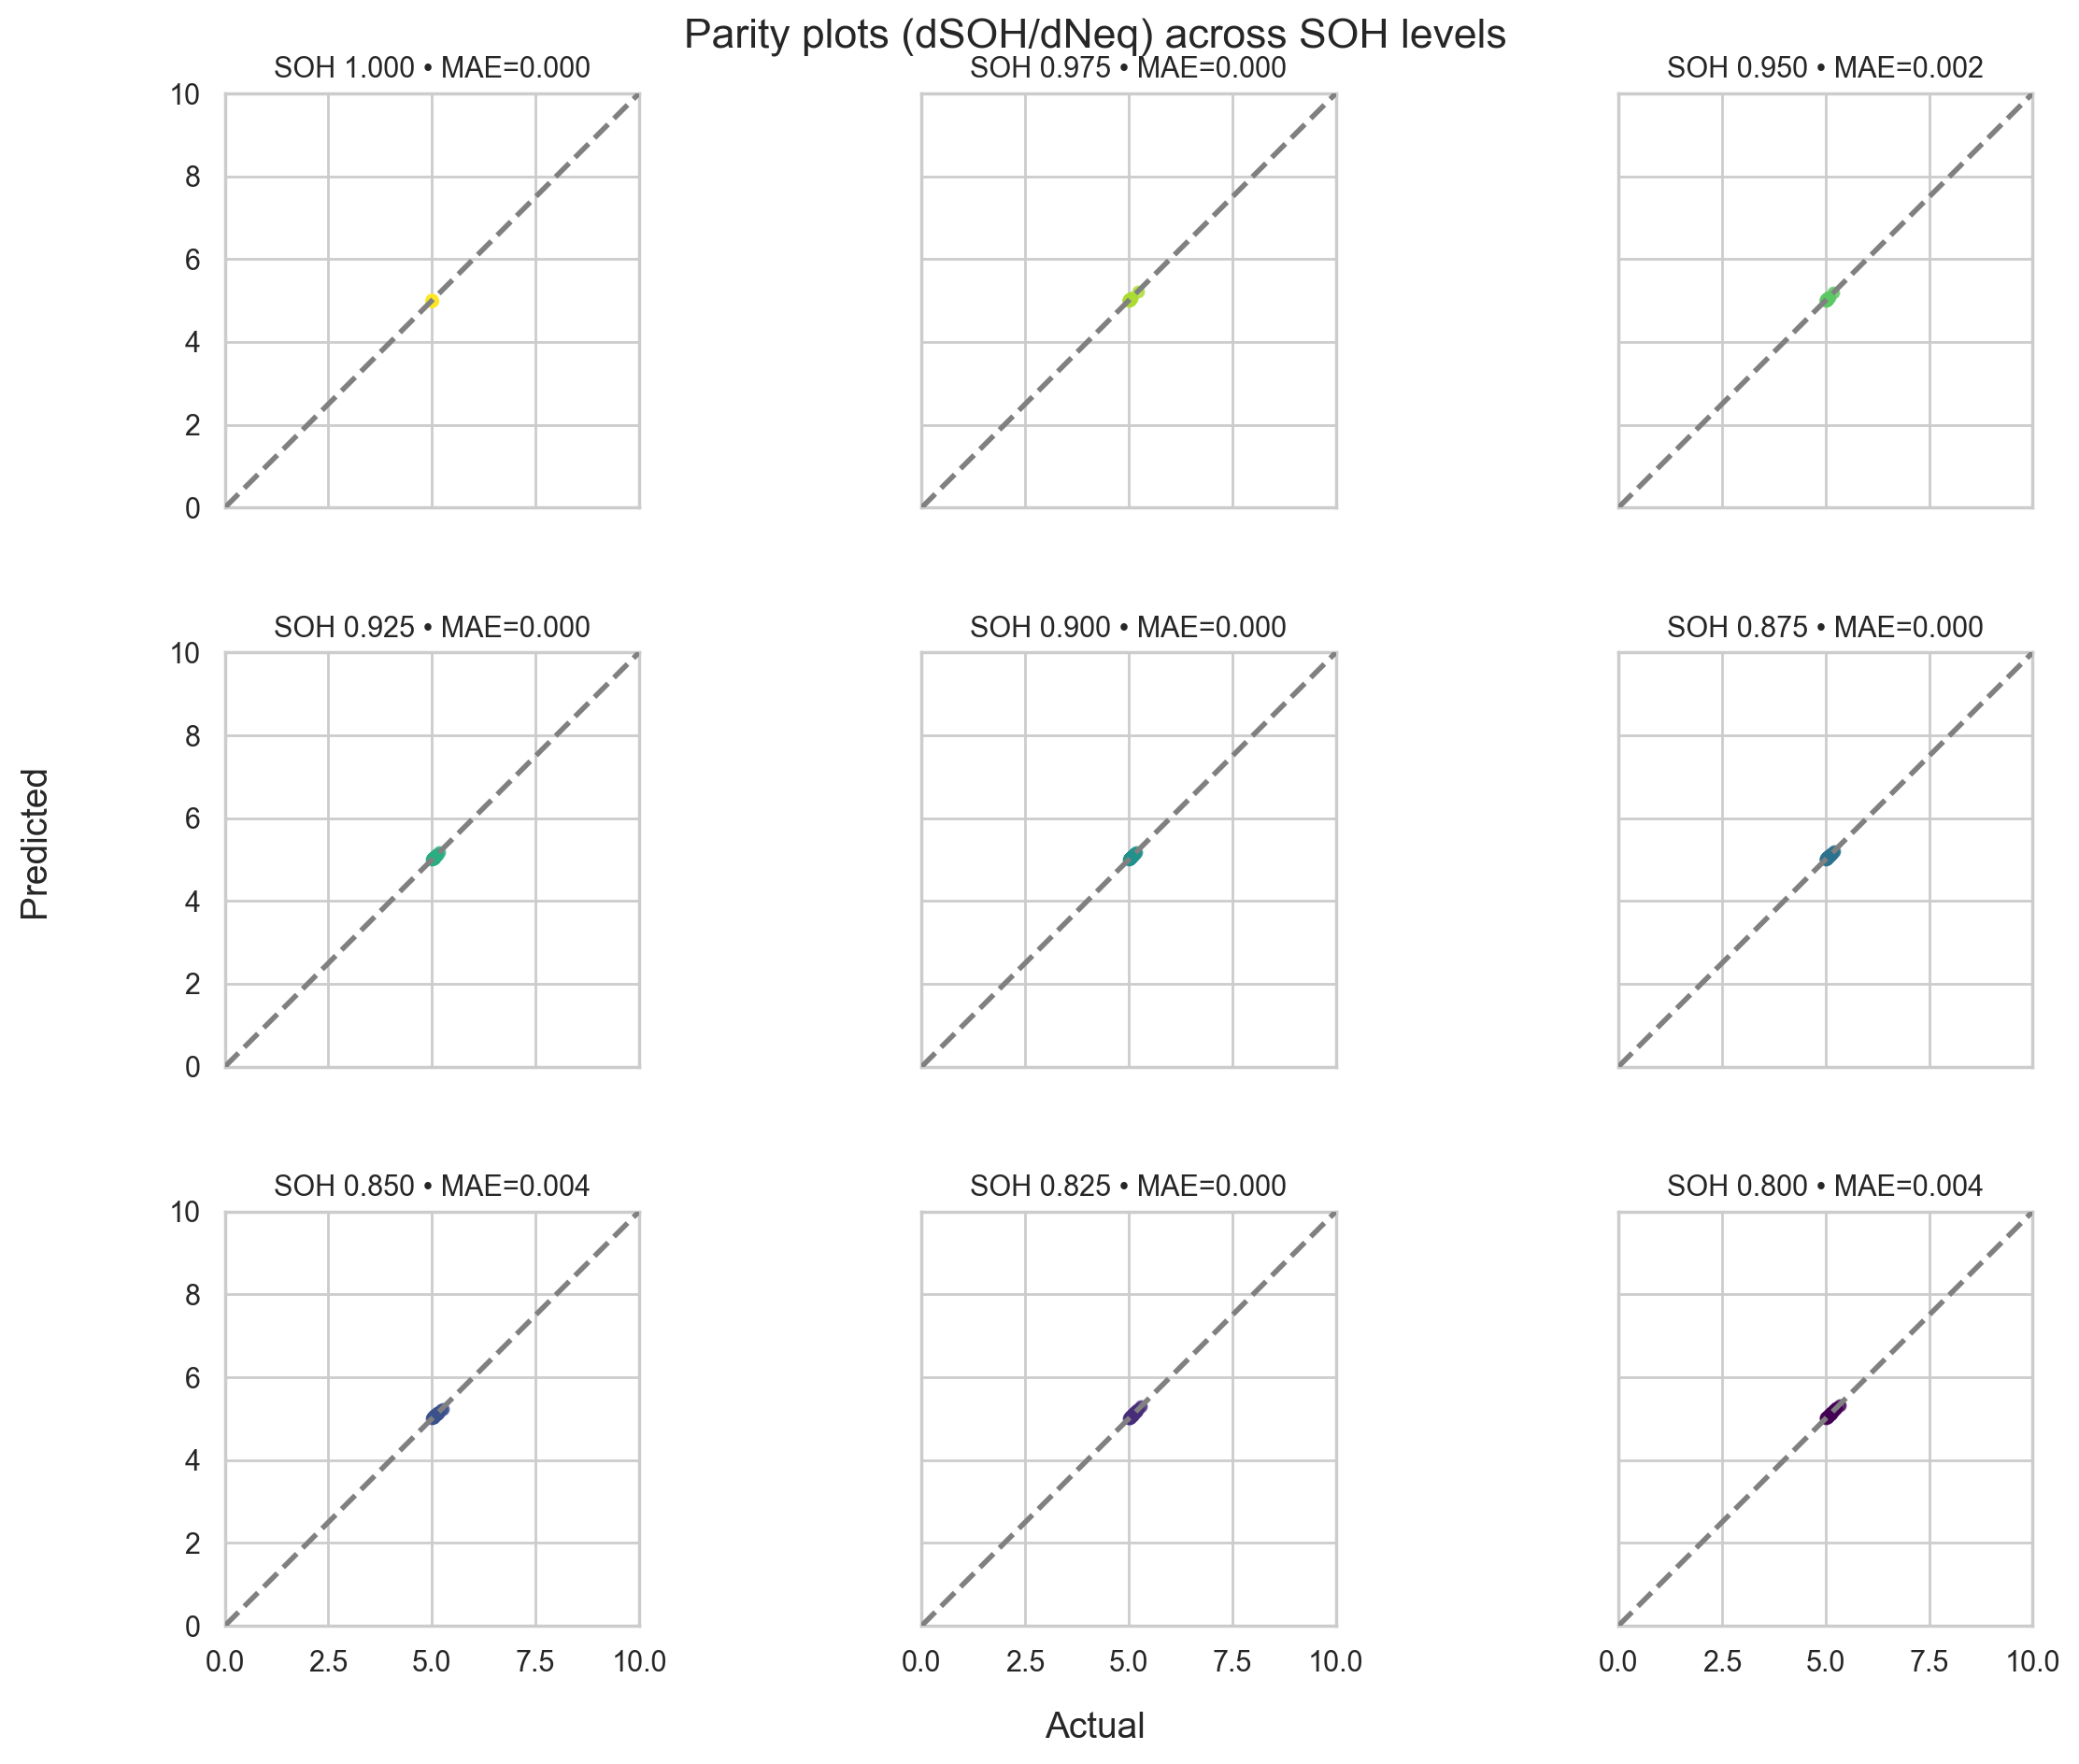

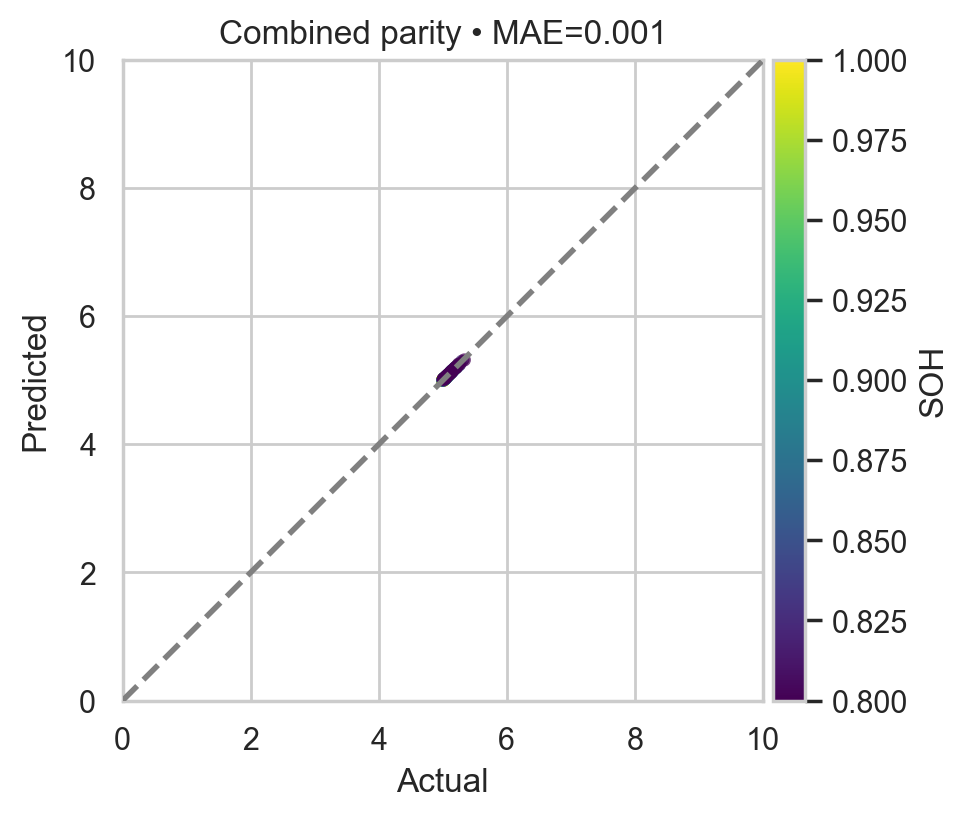

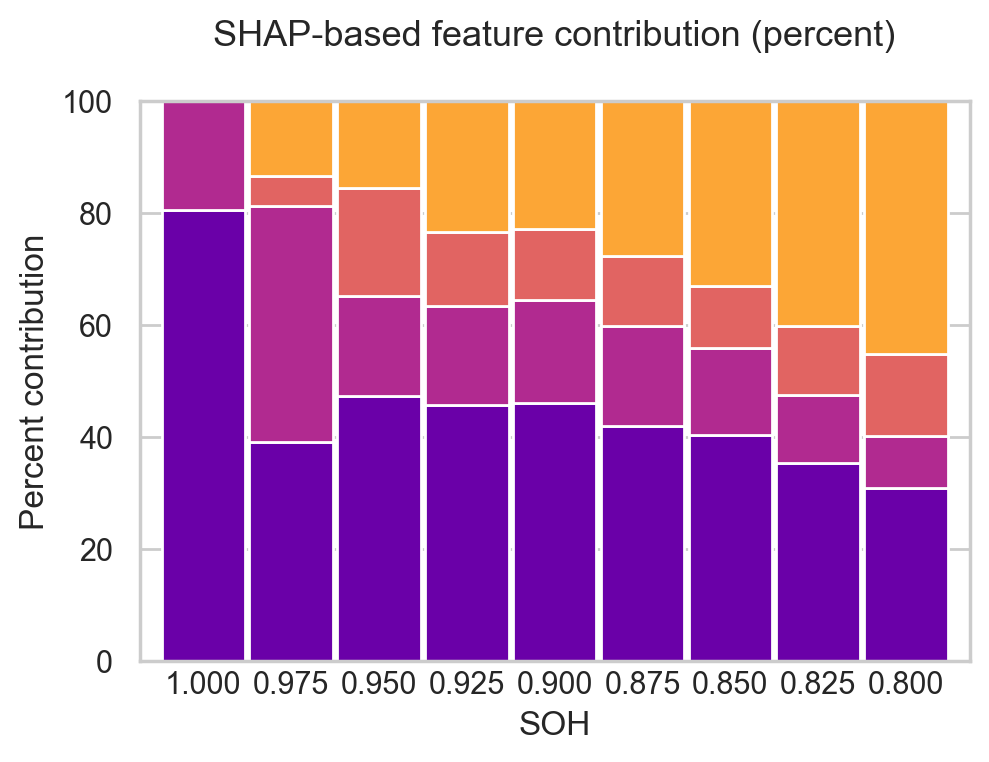

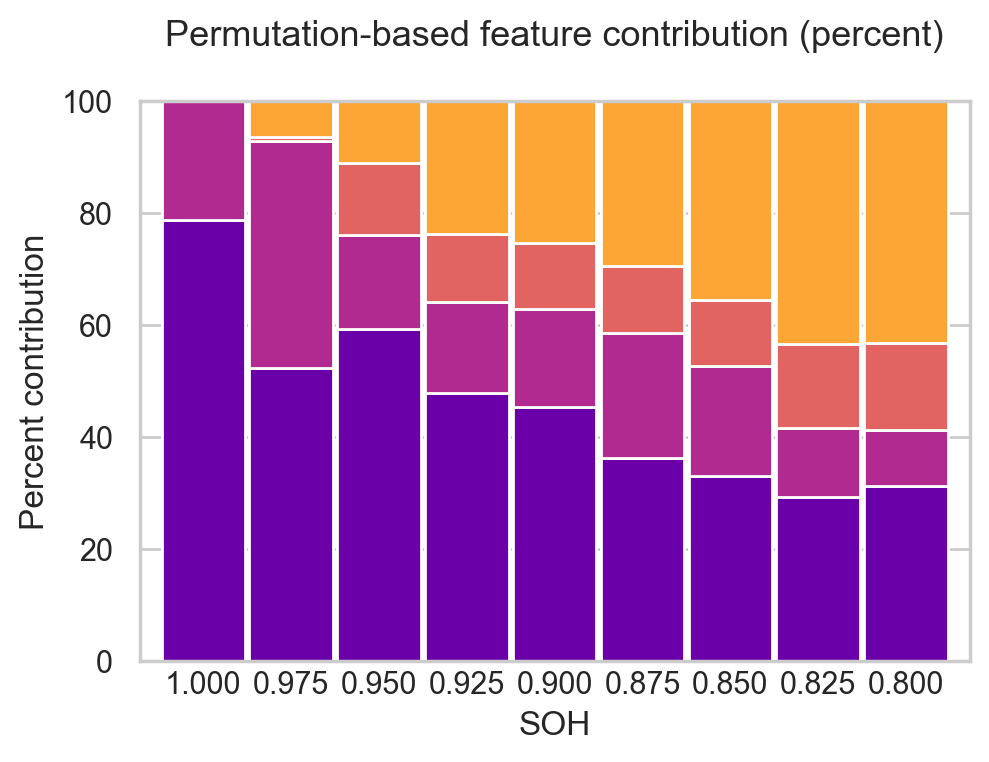

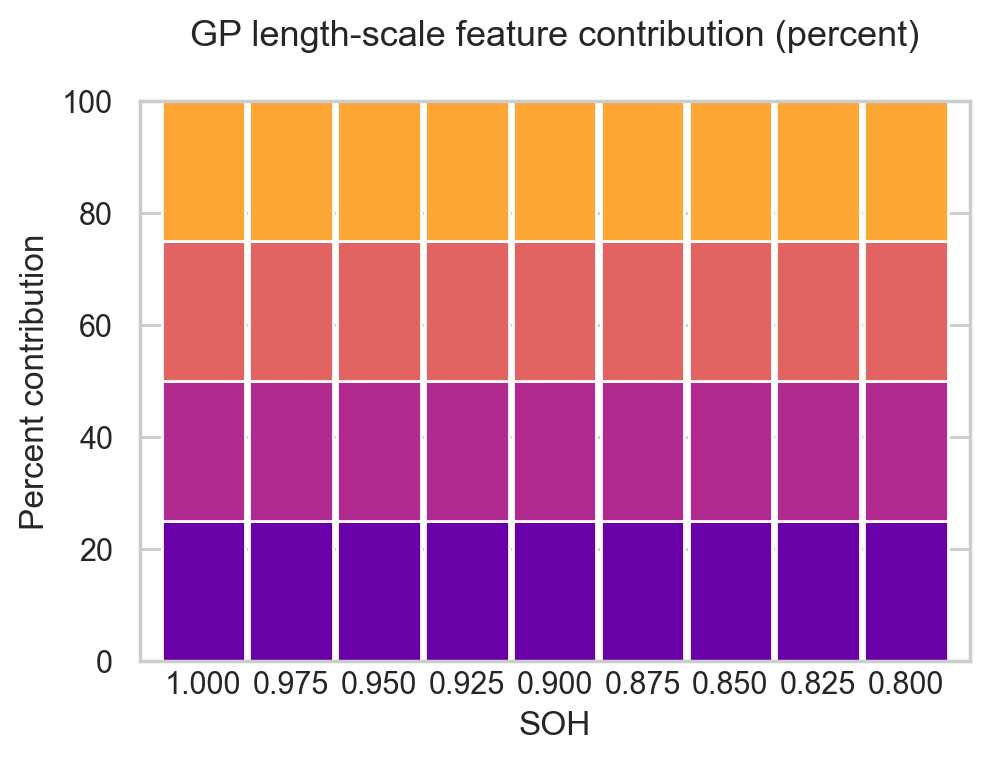

In [178]:
# ==== Imports ====
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.gaussian_process import GaussianProcessRegressor
from sklearn.gaussian_process.kernels import RBF, WhiteKernel, ConstantKernel
from sklearn.inspection import permutation_importance
from sklearn.metrics import mean_absolute_error, mean_absolute_percentage_error

from mpl_toolkits.axes_grid1 import make_axes_locatable
import shap

# ==== Global style ====
plt.rcParamsDefault
sns.reset_defaults()
plt.rcParams['font.sans-serif'] = 'Arial'
plt.rcParams['font.size'] = 12
sns.set_context("paper", font_scale=1.2)
sns.set_theme(style="whitegrid", font="sans-serif")

# ==== Columns ====
FEATURES = ["Ambient temperature", "Discharging current", "Depth of discharge", "Average charging current"]
TARGET = "dSOH/dNeq"

# ==== GP kernel (ARD RBF + constant + white noise) ====
def _make_gpr_kernel(n_features: int):
    rbf = RBF(length_scale=np.ones(n_features), length_scale_bounds=(1e-2, 1e3))
    kernel = ConstantKernel(1.0, (1e-3, 1e3)) * rbf + WhiteKernel(noise_level=1e-3, noise_level_bounds=(1e-6, 1e1))
    return kernel

# ==== GP length-scale heuristic importance ====
def _gp_lengthscale_importance(model: GaussianProcessRegressor, feature_names):
    """
    Heuristic GP importance: importance ~ 1 / length_scale^2 (normalized to %).
    Robust to kernels composed as Constant*RBF + White, etc.
    """
    vals = np.ones(len(feature_names), dtype=float)  # safe fallback

    try:
        K = model.kernel_
        # Collect possible components to look for an RBF
        candidates = [K]
        for obj in list(candidates):
            for attr in ("k1", "k2"):
                if hasattr(obj, attr):
                    candidates.append(getattr(obj, attr))
        rbf = None
        for c in candidates:
            if isinstance(c, RBF):
                rbf = c
                break

        if rbf is not None:
            ls = np.asarray(rbf.length_scale, dtype=float)
            if ls.ndim > 0 and ls.size == len(feature_names):
                vals = 1.0 / (ls**2 + 1e-12)  # shorter length-scale => higher importance
            else:
                vals = np.ones(len(feature_names), dtype=float)
    except Exception:
        pass

    pct = 100.0 * vals / vals.sum()
    return pd.Series(pct, index=feature_names)

# ==== SHAP via KernelExplainer for GP ====
def _shap_kernel_pct(model, X: pd.DataFrame, max_bg=20, max_eval=1000, random_state=1):
    """
    Model-agnostic SHAP using KernelExplainer.
    - Background: k-means on X (up to max_bg); fallback to random sample if k-means fails.
    - Evaluate on up to max_eval rows for speed.
    Returns: Series of % contribution per feature (sums to 100).
    """
    # background
    try:
        background = shap.kmeans(X, max_bg)
    except Exception:
        n_bg = min(max_bg * 2, len(X))
        background = X.sample(n=n_bg, random_state=random_state)

    f = model.predict
    explainer = shap.KernelExplainer(f, background, link="identity")

    if len(X) > max_eval:
        X_eval = X.sample(n=max_eval, random_state=random_state)
    else:
        X_eval = X

    shap_vals = explainer.shap_values(X_eval, nsamples="auto")  # (n_eval, n_features)
    shap_abs_mean = np.mean(np.abs(shap_vals), axis=0)
    pct = np.zeros_like(shap_abs_mean) if shap_abs_mean.sum() == 0 else 100.0 * shap_abs_mean / shap_abs_mean.sum()
    return pd.Series(pct, index=X.columns)

# ==== Fit + explain per SOH ====
def fit_and_explain(df: pd.DataFrame, soh_value: float, random_state: int = 10):
    """Fit GPR; compute predictions, MAE/MAPE, SHAP %, permutation %, and GP length-scale %."""
    X = df[FEATURES].copy()
    y = df[TARGET].astype(float).copy()

    kernel = _make_gpr_kernel(n_features=X.shape[1])
    gpr = GaussianProcessRegressor(kernel=kernel, normalize_y=True, random_state=random_state, n_restarts_optimizer=2)
    gpr.fit(X, y)
    y_pred = gpr.predict(X)

    mae  = mean_absolute_error(y, y_pred)
    mape = mean_absolute_percentage_error(y, y_pred)

    shap_pct   = _shap_kernel_pct(gpr, X)
    perm       = permutation_importance(gpr, X, y, n_repeats=20, random_state=42, n_jobs=-1)
    perm_mean  = np.asarray(perm.importances_mean, dtype=float)
    perm_pct   = 100.0 * np.abs(perm_mean) / np.sum(np.abs(perm_mean)) if np.sum(np.abs(perm_mean)) > 0 else np.zeros_like(perm_mean)
    perm_pct   = pd.Series(perm_pct, index=FEATURES)

    length_pct = _gp_lengthscale_importance(gpr, FEATURES)

    return {
        "soh": soh_value,
        "y_true": y.values,
        "y_pred": y_pred,
        "mae": mae,
        "mape": mape,
        "shap_pct": shap_pct,
        "perm_pct": perm_pct,
        "length_pct": length_pct,  # guaranteed
    }

# ==== Utilities ====
def percent_df(rows, key, index_name="SOH"):
    """
    Robust builder of a dataframe with rows indexed by SOH and columns=FEATURES,
    from stored Series in results under `key`. Skips missing safely.
    """
    series_rows, index_vals, missing = [], [], []
    for r in rows:
        if key in r and isinstance(r[key], (pd.Series, pd.DataFrame)):
            series_rows.append(r[key])
            index_vals.append(r["soh"])
        else:
            missing.append(r.get("soh", None))
    if missing:
        print(f"[percent_df] Skipped SOH (no '{key}'): {missing}")

    if not series_rows:
        return pd.DataFrame(columns=FEATURES)

    df = pd.DataFrame(series_rows, index=index_vals)
    df.index.name = index_name
    return df.loc[sorted(df.index, reverse=True)]

def add_diagonal(ax, lim):
    ax.plot([0, lim], [0, lim], ls="--", lw=2, color="grey", zorder=3)

# ==== Orchestrator: provide your SOH_* dataframes beforehand ====
# Example mapping (assumes SOH_100, SOH_0975, ..., SOH_0800 already exist)
soh_to_df = {
    1.000: SOH_100,
    0.975: SOH_0975,
    0.950: SOH_0950,
    0.925: SOH_0925,
    0.900: SOH_0900,
    0.875: SOH_0875,
    0.850: SOH_0850,
    0.825: SOH_0825,
    0.800: SOH_0800,
}

# Fit all slices
results = []
for soh_val in sorted(soh_to_df.keys(), reverse=True):
    out = fit_and_explain(soh_to_df[soh_val], soh_val)
    results.append(out)

# ==== 3×3 parity plots ====
all_y_true = np.concatenate([r["y_true"] for r in results])
all_y_pred = np.concatenate([r["y_pred"] for r in results])
max_lim = max(all_y_true.max(), all_y_pred.max())
max_lim = float(np.ceil(max_lim * 20) / 20)  # round up to nearest 0.05
max_lim = max(max_lim, 10)                 # enforce minimum like your previous style

fig, axes = plt.subplots(3, 3, figsize=(12, 10), sharex=True, sharey=True)
axes = axes.flatten()

cmap = plt.cm.viridis
norm = plt.Normalize(vmin=min(soh_to_df.keys()), vmax=max(soh_to_df.keys()))

for ax, r in zip(axes, results):
    soh = r["soh"]
    ax.scatter(r["y_true"], r["y_pred"], alpha=0.75, s=16, c=[cmap(norm(soh))])
    add_diagonal(ax, max_lim)
    ax.set_xlim(0, max_lim)
    ax.set_ylim(0, max_lim)
    ax.set_aspect("equal", adjustable="box")
    ax.set_title(f"SOH {soh:.3f} • MAE={r['mae']:.3f}", fontsize=11)

# Hide unused axes (none expected for 9)
for i in range(len(results), len(axes)):
    axes[i].axis("off")

fig.suptitle("Parity plots (dSOH/dNeq) across SOH levels", y=0.94, fontsize=16)
fig.text(0.5, 0.02, "Actual", ha="center", fontsize=14)
fig.text(0.02, 0.5, "Predicted", va="center", rotation="vertical", fontsize=14)
plt.subplots_adjust(left=0.08, right=0.95, top=0.90, bottom=0.08, wspace=0.25, hspace=0.35)
plt.show()

# ==== Combined parity with matched-height colorbar ====
fig, ax = plt.subplots(figsize=(5, 5))
for r in results:
    soh = r["soh"]
    clr = cmap(norm(soh))
    ax.scatter(r["y_true"], r["y_pred"], alpha=0.7, s=14, c=[clr]*len(r["y_pred"]))

add_diagonal(ax, max_lim)
ax.set_xlim(0, max_lim)
ax.set_ylim(0, max_lim)
ax.set_aspect("equal", adjustable="box")
ax.set_xlabel("Actual")
ax.set_ylabel("Predicted")
overall_mae = mean_absolute_error(all_y_true, all_y_pred)
ax.set_title(f"Combined parity • MAE={overall_mae:.3f}")

divider = make_axes_locatable(ax)
cax = divider.append_axes("right", size="5%", pad=0.05)  # same height as ax
mappable = plt.cm.ScalarMappable(norm=norm, cmap=cmap)
cbar = plt.colorbar(mappable, cax=cax)
cbar.set_label("SOH")

plt.tight_layout()
plt.show()

# ==== Combined stacked bars (uniform size/scale) ====
shap_df   = percent_df(results, "shap_pct")
perm_df   = percent_df(results, "perm_pct")
length_df = percent_df(results, "length_pct")

FIGSIZE_STACKED = (5, 4)
YLIM_STACKED = (0, 100)
feature_colors = sns.color_palette("plasma", n_colors=len(FEATURES))

def stacked_bar(df, title, ylabel="Percent contribution", show_legend=False, savepath=None):
    fig, ax = plt.subplots(figsize=FIGSIZE_STACKED)
    df.plot.bar(stacked=True, color=feature_colors, width=0.95, ax=ax)
    ax.set_xlabel("SOH", fontsize=12)
    ax.set_ylabel(ylabel, fontsize=12)
    ax.set_title(title, fontsize=13, pad=20)
    ax.set_xticklabels([f"{idx:.3f}" for idx in df.index], rotation=0)
    ax.tick_params(axis='x', which='both', length=0)
    ax.set_ylim(*YLIM_STACKED)
    if show_legend:
        ax.legend(loc='upper left', bbox_to_anchor=(1.02, 1), title='Features',
                  frameon=False, fontsize=10, title_fontsize=11)
    else:
        if ax.legend_:
            ax.legend_.remove()
    plt.subplots_adjust(left=0.12, right=0.95, top=0.85, bottom=0.15)
    if savepath:
        fig.savefig(savepath, dpi=300, bbox_inches="tight")
    plt.show()

stacked_bar(shap_df,   "SHAP-based feature contribution (percent)")
stacked_bar(perm_df,   "Permutation-based feature contribution (percent)")
stacked_bar(length_df, "GP length-scale feature contribution (percent)")
